In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
shotsDF = pd.read_csv('shot_logs.csv')
statsDF = pd.read_csv('players_stats.csv')


# --- columns (change if your names differ) ---
PLAYER_COL = 'player_name'
POINTS_COL = 'PTS'   # points credited on that shot (0, 2, or 3)

# --- per-player totals ---
per_player = (shotsDF
              .groupby(PLAYER_COL, as_index=True)
              .agg(
                  total_FGA = (PLAYER_COL, 'size'),   # count of rows = number of shots
                  total_pts = (POINTS_COL, 'sum')     # sum points scored
              ))

# --- PTS per FGA (points per shot) ---
per_player['pts_per_fga'] = np.where(
    per_player['total_FGA'] > 0,
    per_player['total_pts'] / per_player['total_FGA'],
    np.nan
)

# neat preview
print(per_player.head(10))


Matplotlib is building the font cache; this may take a moment.


                 total_FGA  total_pts  pts_per_fga
player_name                                       
aaron brooks           561        555     0.989305
aaron gordon           104        119     1.144231
al farouq aminu        258        248     0.961240
al horford             715        783     1.095105
al jefferson           800        766     0.957500
alan anderson          337        352     1.044510
alan crabbe             94        102     1.085106
alex len               299        317     1.060201
alexis ajinca          211        252     1.194313
alonzo gee             138        143     1.036232


In [2]:
shotsDF
statsDF


,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,AJ Price,26,324,133,51,137,37.2,15,57,26.3,...,29.0,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.798393
1,Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,...,30.0,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.361111
2,Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,...,20.0,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.142661
3,Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,...,24.0,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.377751
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,Xavier Henry,9,86,20,3,13,23.1,0,0,0.0,...,24.0,be,"March 15, 1991",University of Kansas,4,195.0,SF,LAL,99.00,26.035503
486,Zach LaVine,77,1902,778,286,677,42.2,57,167,34.1,...,20.0,us,"March 10, 1995","University of California, Los Angeles",R,192.5,PG,MIN,85.05,22.951594
487,Zach Randolph,71,2304,1143,454,932,48.7,7,20,35.0,...,34.0,us,"July 16, 1981",Michigan State University,13,202.5,PF,MEM,117.00,28.532236
488,Zaza Pachulia,73,1730,606,240,529,45.4,0,3,0.0,...,31.0,ge,"February 10, 1984",NaN,11,207.5,C,MIL,121.50,28.218900


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_6086/4014447004.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = shotsDF.groupby('sc_bin').size()


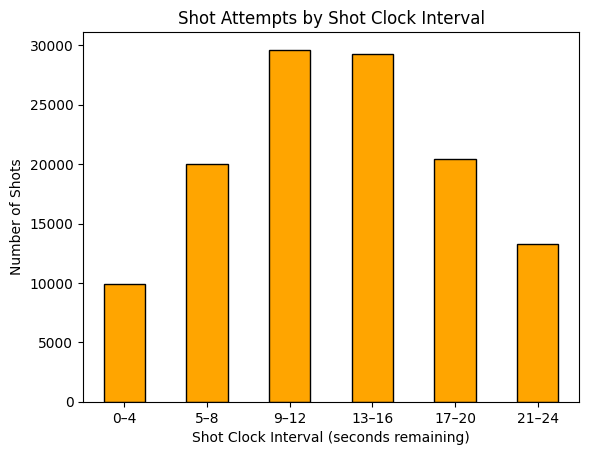

In [ ]:
#Looking at if later in the shotclock does effect the mix matches

import pandas as pd
import numpy as np

# assume df['shot_clock'] has seconds remaining (0–24), floats or ints
# (optional) clip weird values and drop NaNs
s = shotsDF['SHOT_CLOCK'].clip(lower=0, upper=24)

bins   = [0, 4, 8, 12, 16, 20, 24]  # right-closed bins → (20,24], etc.
labels = ['0–4','5–8','9–12','13–16','17–20','21–24']

shotsDF['sc_bin'] = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=True)

# example aggregations
#counts = shotsDF.groupby('sc_bin').size()
#means  = shotsDF.groupby('sc_bin')['some_metric'].mean()

counts = shotsDF.groupby('sc_bin').size()

counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Shot Attempts by Shot Clock Interval")
plt.xlabel("Shot Clock Interval (seconds remaining)")
plt.ylabel("Number of Shots")
plt.xticks(rotation=0)
plt.show()

total_shots = shotsDF.shape[0]

total_mixmatches = 0

for i in range(total_shots):
    shooter = shotsDF.loc[i, "player_name"]
    defender = shotsDF.loc[i, "CLOSEST_DEFENDER"]

    shooterPosition = ''
    defenderPosition = ''
    for j in range(statsDF.shape[0]):
        if shooter == statsDF.loc[j,"Name"]:
            shooterPosition = statsDF.loc[j,'Pos']

        if defender == statsDF.loc[j,"Name"]:
            defenderPosition = statsDF.loc[j,'Pos']
    if shooterPosition != defenderPosition:
        total_mixmatches += 1

print(total_mixmatches)



/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/1684504444.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = shotsDF.groupby('sc_bin').size()


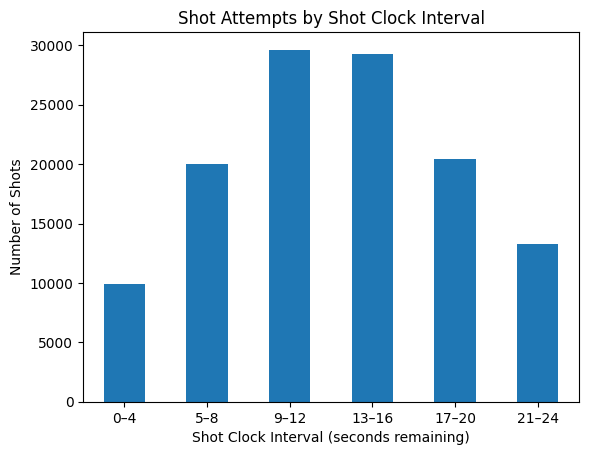

Total shots: 128069
Total mismatches (positions known): 202


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/1684504444.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


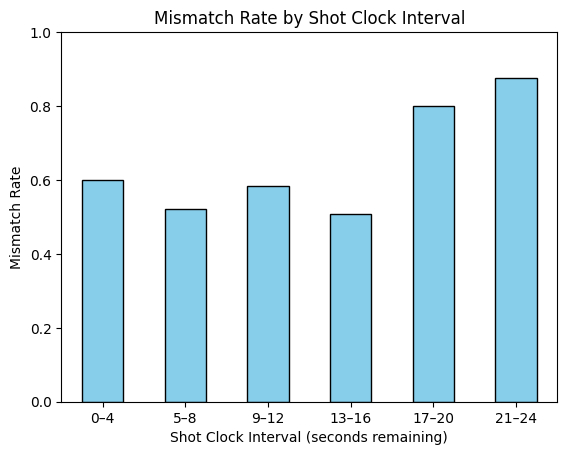

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helper to normalize names (remove capitalization + strip spaces) ---
def norm_name(name):
    """
    Normalize a player's name by lowercasing and stripping whitespace.
    """
    if not isinstance(name, str):
        return name
    return name.strip().lower()

# --- Bin shot clock into 4-second intervals ---
s = shotsDF['SHOT_CLOCK'].clip(lower=0, upper=24)
bins   = [0, 4, 8, 12, 16, 20, 24]
labels = ['0–4','5–8','9–12','13–16','17–20','21–24']
shotsDF['sc_bin'] = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=True)
shotsDF['sc_bin'] = shotsDF['sc_bin'].cat.as_ordered()  # keep logical order

# --- Plot counts by bin ---
counts = shotsDF.groupby('sc_bin').size()
counts.plot(kind='bar')
plt.title("Shot Attempts by Shot Clock Interval")
plt.xlabel("Shot Clock Interval (seconds remaining)")
plt.ylabel("Number of Shots")
plt.xticks(rotation=0)
plt.show()

# --- Build a name -> position map from statsDF ---
pos_map = (statsDF
           .assign(_name=statsDF['Name'].map(norm_name))
           .drop_duplicates('_name')
           .set_index('_name')['Pos'])

# --- Normalize shooter/defender names in shotsDF ---
shotsDF['_shooter_name']  = shotsDF['player_name'].map(norm_name)
shotsDF['_defender_name'] = shotsDF['CLOSEST_DEFENDER'].map(norm_name)

# --- Map positions ---
shotsDF['shooter_pos']  = shotsDF['_shooter_name'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_name'].map(pos_map)

# --- Define mismatches (only when both positions are known) ---
known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

# --- Totals ---
total_shots       = len(shotsDF)
total_mismatches  = shotsDF.loc[known, 'mismatch'].sum()
print("Total shots:", total_shots)
print("Total mismatches (positions known):", int(total_mismatches))

# --- Mismatch rate by shot clock bin ---
mismatch_rate = (shotsDF.loc[known]
                 .groupby('sc_bin')['mismatch']
                 .mean())

# --- Plot mismatch rate by bin ---
mismatch_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Mismatch Rate by Shot Clock Interval")
plt.xlabel("Shot Clock Interval (seconds remaining)")
plt.ylabel("Mismatch Rate")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()


In [ ]:
import pandas as pd

positions = statsDF['Pos'].notnull()

def map_position(pos):
    if not isinstance(pos, str):
        return np.nan
    pos = pos.upper()
    if "PG" in pos:
        return "PG"
    if "SG" in pos:
        return "SG"
    if "SF" in pos:
        return "SF"
    if "PF" in pos:
        return "PF"
    if "C" in pos:
        return "C"
    
    return np.nan

statsDF['PositionGroups'] =  statsDF['Pos'].map(map_position)

print(statsDF['PositionGroups'].value_counts())




PositionGroups
SG    100
PF     90
PG     84
SF     76
C      72
Name: count, dtype: int64


Known shooter/defender pairs: 97284
Total mismatches (known only): 59200
Mismatch rate (known only): 0.6085

Sample raw defenders: ['Anderson, Alan', 'Bogdanovic, Bojan', 'Bogdanovic, Bojan', 'Brown, Markel', 'Young, Thaddeus']
Sample norm defenders: ['alan anderson', 'bojan bogdanovic', 'bojan bogdanovic', 'markel brown', 'thaddeus young']


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/1360340120.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = shotsDF.groupby('sc_bin').size()


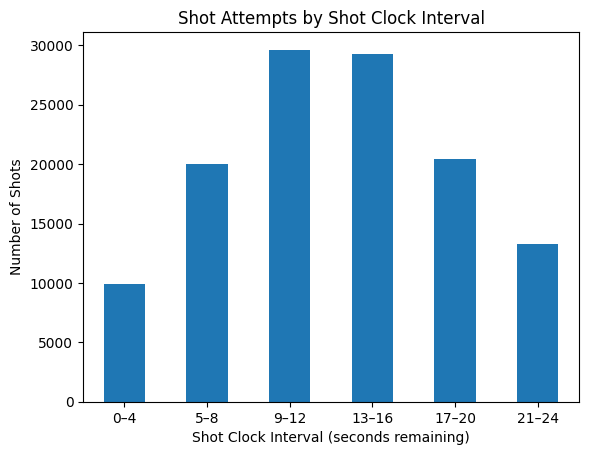

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/1360340120.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


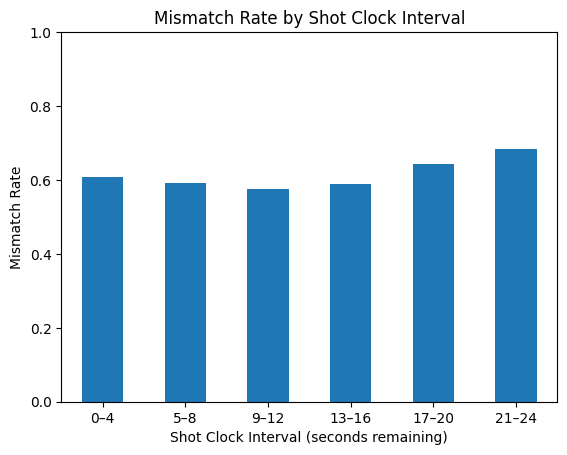

In [ ]:
#SG Mixmatches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata

# =========================================================
# === NEW: robust name normalizer for 'Last, First' etc. ==
# =========================================================
def norm_name(s):
    """
    Normalize a player's name so formats like 'James, LeBron' → 'lebron james'.
    - flips 'Last, First' to 'First Last' if a comma is present
    - strips whitespace
    - removes accents (e.g., 'Đ' -> 'D')
    - removes common suffixes (jr., sr., ii, iii, iv)
    - removes punctuation (commas/periods)
    - collapses multiple spaces
    - lowercases
    """
    if not isinstance(s, str):
        return s
    s = s.strip()

    # remove unicode accents
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))

    # flip 'Last, First' -> 'First Last'
    if ',' in s:
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"

    # remove common suffixes
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)

    # remove common punctuation (commas handled above)
    s = re.sub(r'[.]', '', s)

    # collapse spaces + lowercase
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# =========================================================
# (Optional) Map raw positions to 5 buckets PG/SG/SF/PF/C
# If you already have statsDF['PositionGroups'], you can skip.
# =========================================================
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG", "SG", "SF", "PF", "C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

if 'PositionGroups' not in statsDF.columns:
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# =========================================================
# Build name -> position map from statsDF   (USES NEW norm)
# =========================================================
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF
           .drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# =========================================================
# Normalize shooter/defender names in shotsDF  (USES NEW norm)
# =========================================================
shotsDF['_shooter_norm']  = shotsDF['player_name'].map(norm_name)
shotsDF['_defender_norm'] = shotsDF['CLOSEST_DEFENDER'].map(norm_name)

# =========================================================
# Map positions onto shots, compute mismatch
# =========================================================
shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known shooter/defender pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))
print("Mismatch rate (known only):", round(float(shotsDF.loc[known, 'mismatch'].mean()), 4))

# (Optional) Quick peek to verify normalization worked as intended
print("\nSample raw defenders:", shotsDF['CLOSEST_DEFENDER'].head(5).tolist())
print("Sample norm defenders:", shotsDF['_defender_norm'].head(5).tolist())

# =========================================================
# Shot clock 4-second bins + charts (unchanged logic)
# =========================================================
s = shotsDF['SHOT_CLOCK'].clip(lower=0, upper=24)
bins   = [0, 4, 8, 12, 16, 20, 24]
labels = ['0–4','5–8','9–12','13–16','17–20','21–24']
shotsDF['sc_bin'] = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=True)
shotsDF['sc_bin'] = shotsDF['sc_bin'].cat.as_ordered()

# Attempts by bin
counts = shotsDF.groupby('sc_bin').size()
ax = counts.plot(kind='bar')
ax.set_title("Shot Attempts by Shot Clock Interval")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Number of Shots")
plt.xticks(rotation=0)
plt.show()

# Mismatch rate by bin (only where both positions known)
mismatch_rate = (shotsDF.loc[known]
                 .groupby('sc_bin')['mismatch']
                 .mean())
ax = mismatch_rate.plot(kind='bar')
ax.set_title("Mismatch Rate by Shot Clock Interval")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Mismatch Rate")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()



==== PG ====
Total shots: 25521
Known shots: 25521
Mismatches: 12967
Mismatch rate: 0.5081


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = subset.groupby('sc_bin').size()


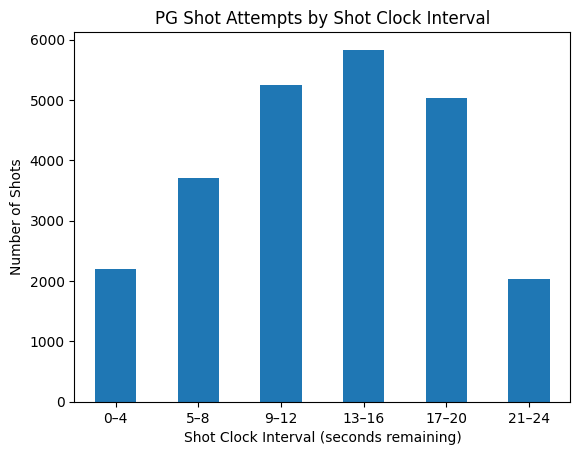

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


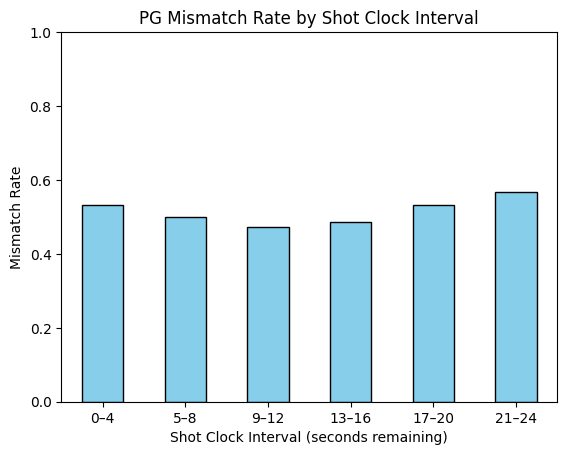


==== SG ====
Total shots: 25580
Known shots: 25580
Mismatches: 15091
Mismatch rate: 0.59


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = subset.groupby('sc_bin').size()


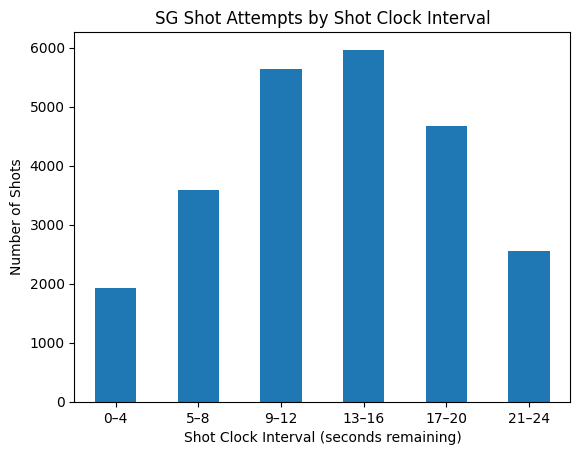

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


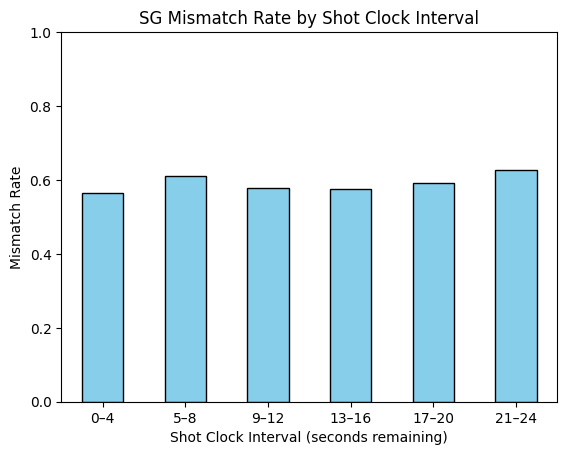


==== SF ====
Total shots: 18400
Known shots: 18400
Mismatches: 11055
Mismatch rate: 0.6008


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = subset.groupby('sc_bin').size()


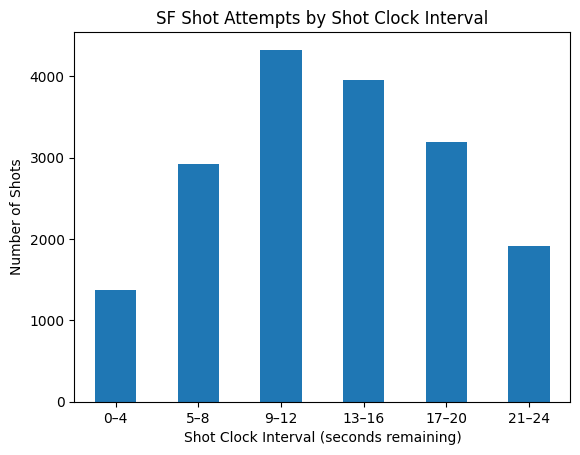

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


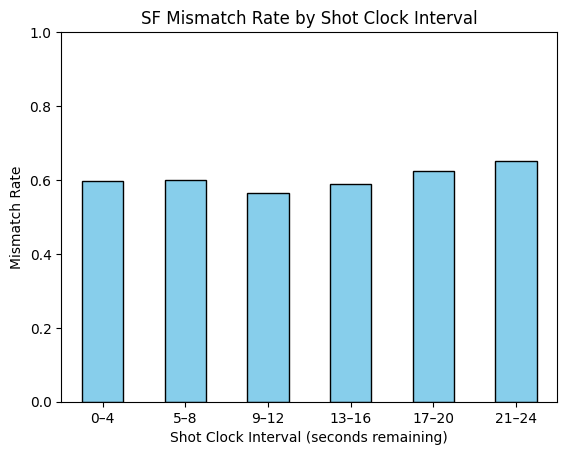


==== PF ====
Total shots: 23087
Known shots: 23087
Mismatches: 11745
Mismatch rate: 0.5087


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = subset.groupby('sc_bin').size()


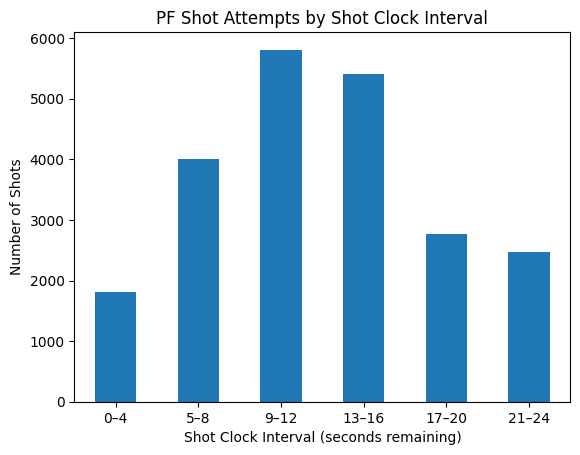

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


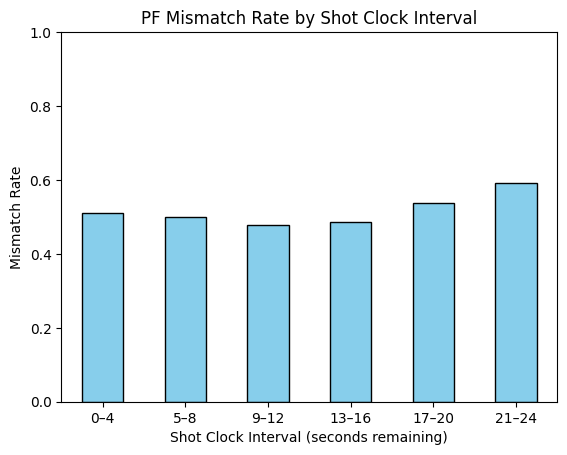


==== C ====
Total shots: 18004
Known shots: 18004
Mismatches: 8342
Mismatch rate: 0.4633


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = subset.groupby('sc_bin').size()


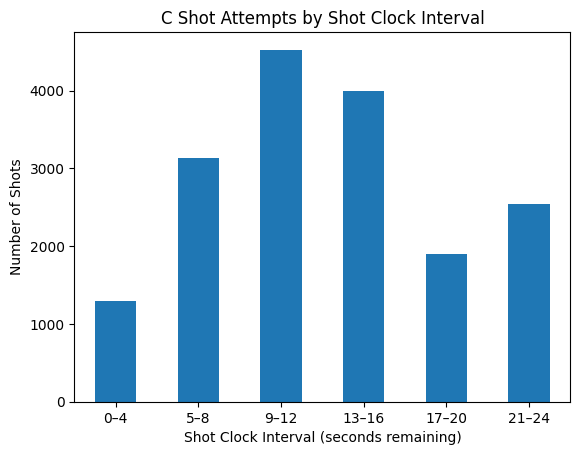

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/787004549.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


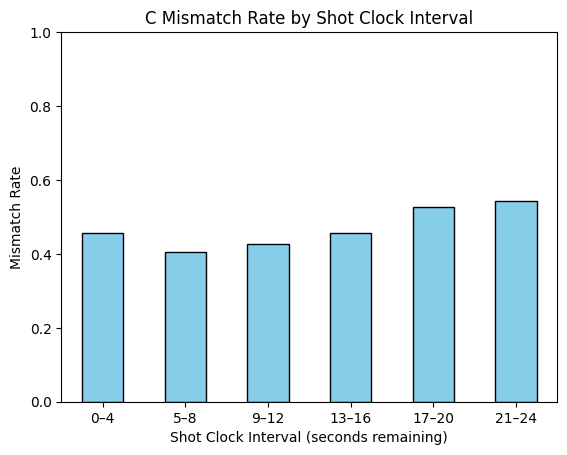

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata

# =========================================================
# === Name normalizer (handles 'Last, First') ===
# =========================================================
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:   # flip Last, First -> First Last
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# =========================================================
# === Position bucketing to 5 groups (PG/SG/SF/PF/C) ===
# =========================================================
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG", "SG", "SF", "PF", "C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

if 'PositionGroups' not in statsDF.columns:
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF.drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

shotsDF['_shooter_norm']  = shotsDF['player_name'].map(norm_name)
shotsDF['_defender_norm'] = shotsDF['CLOSEST_DEFENDER'].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

# =========================================================
# === Shot clock bins (same as before) ===
# =========================================================
s = shotsDF['SHOT_CLOCK'].clip(lower=0, upper=24)
bins   = [0, 4, 8, 12, 16, 20, 24]
labels = ['0–4','5–8','9–12','13–16','17–20','21–24']
shotsDF['sc_bin'] = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=True)
shotsDF['sc_bin'] = shotsDF['sc_bin'].cat.as_ordered()

# =========================================================
# === Loop over each position group ===
# =========================================================
for pos in ["PG","SG","SF","PF","C"]:
    subset = shotsDF.loc[shotsDF['shooter_pos'] == pos].copy()
    k = subset['mismatch'].notna()
    
    total_shots = len(subset)
    total_known = k.sum()
    mismatches  = int(subset.loc[k, 'mismatch'].sum())
    rate        = float(subset.loc[k, 'mismatch'].mean()) if total_known>0 else np.nan

    print(f"\n==== {pos} ====")
    print("Total shots:", total_shots)
    print("Known shots:", total_known)
    print("Mismatches:", mismatches)
    print("Mismatch rate:", round(rate, 4))

    # Chart: attempts by bin
    counts = subset.groupby('sc_bin').size()
    counts.plot(kind='bar', title=f"{pos} Shot Attempts by Shot Clock Interval")
    plt.xlabel("Shot Clock Interval (seconds remaining)")
    plt.ylabel("Number of Shots")
    plt.xticks(rotation=0)
    plt.show()

    # Chart: mismatch rate by bin
    mismatch_rate = (subset.loc[k]
                     .groupby('sc_bin')['mismatch']
                     .mean())
    mismatch_rate.plot(kind='bar', color='skyblue', edgecolor='black',
                       title=f"{pos} Mismatch Rate by Shot Clock Interval")
    plt.xlabel("Shot Clock Interval (seconds remaining)")
    plt.ylabel("Mismatch Rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.show()


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = shotsDF.groupby('sc_bin').size()


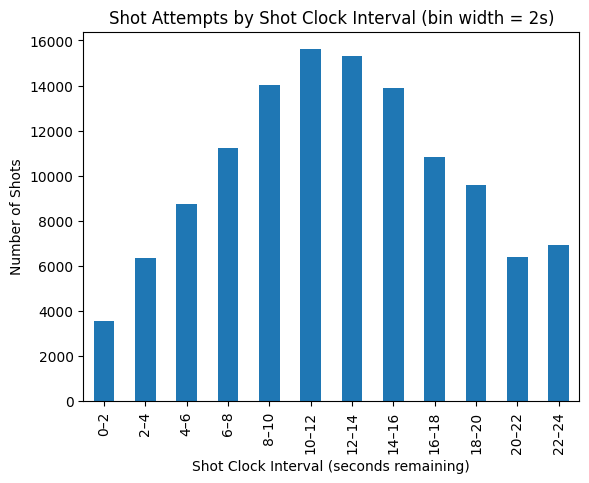

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


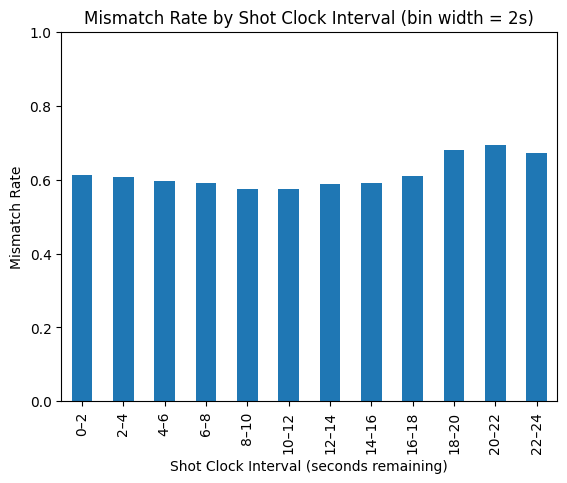

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


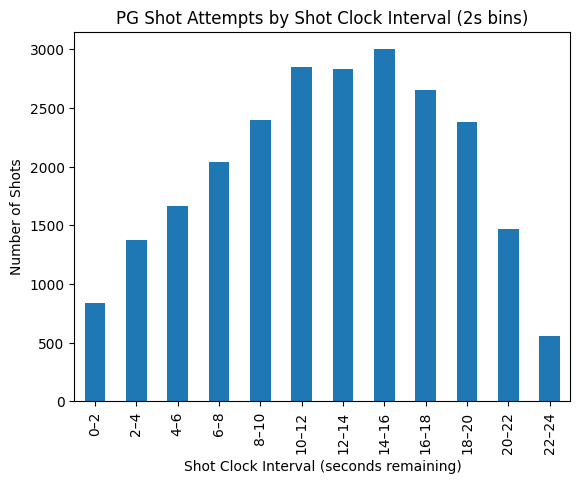

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


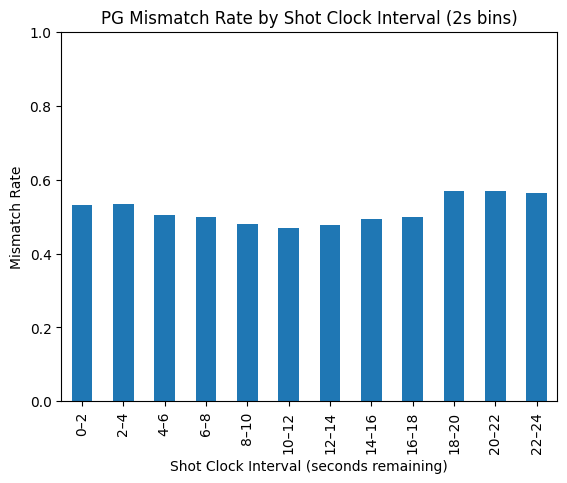

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


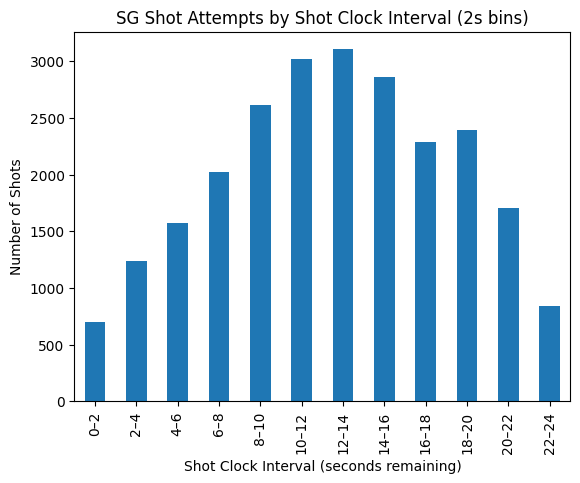

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


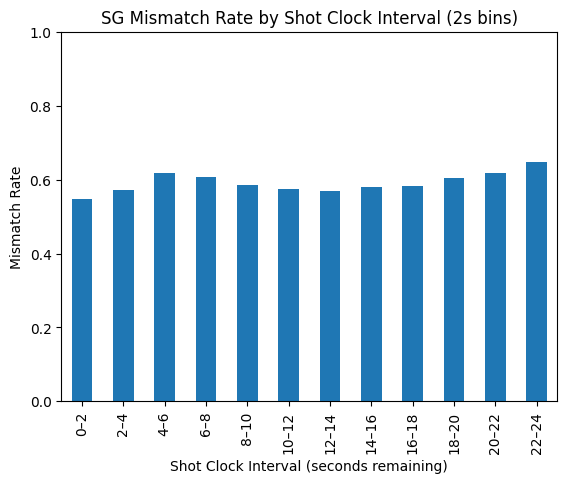

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


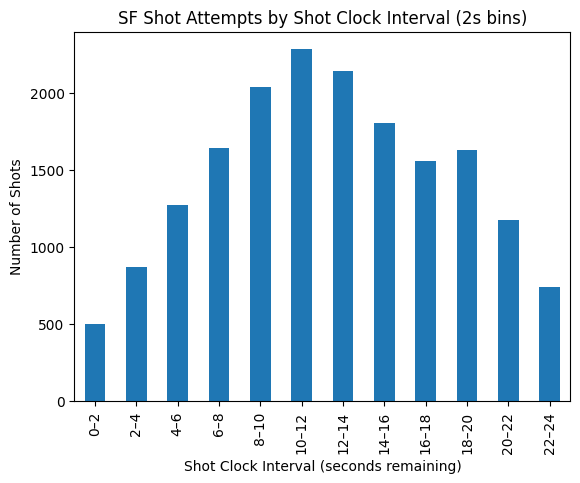

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


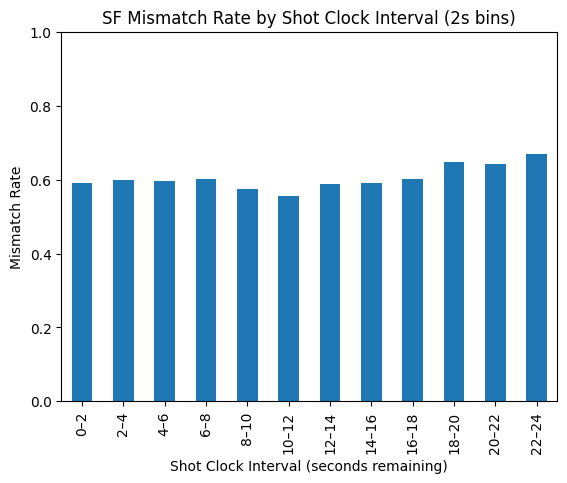

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


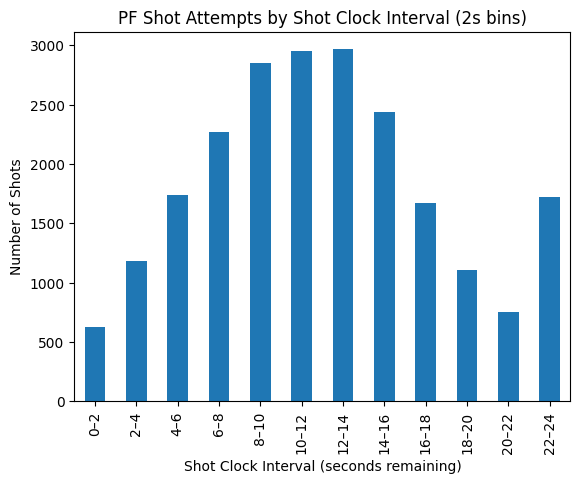

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


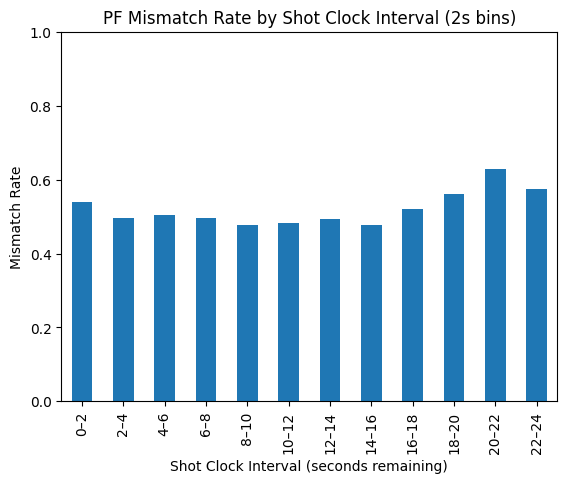

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


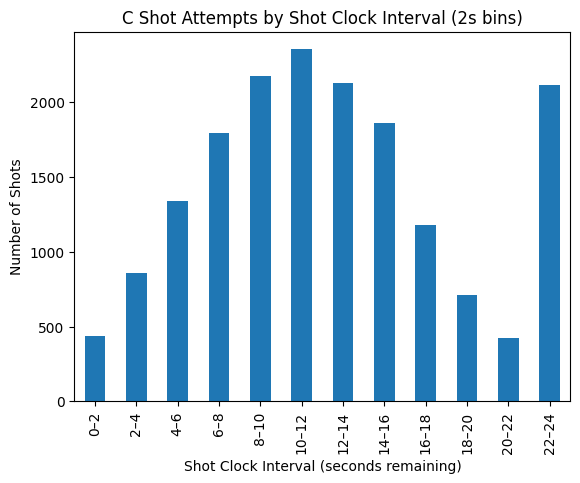

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/3477387323.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


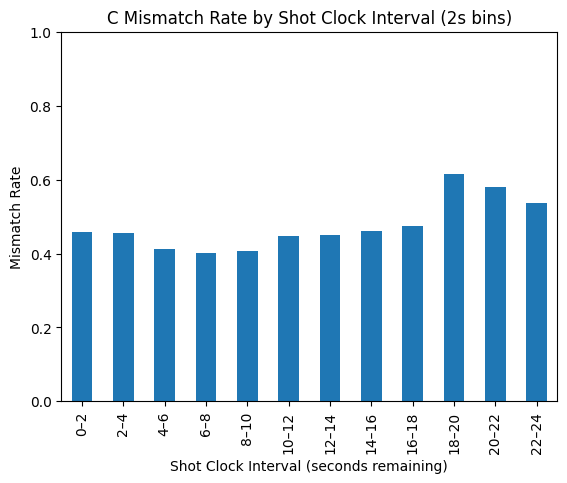

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata

# ----- Name normalizer (keeps your matching solid, incl. "Last, First") -----
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# ----- (Optional) map to 5 positions if not already present -----
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

if 'PositionGroups' not in statsDF.columns:
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# ----- Build name -> position map -----
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF.drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# ----- Normalize names on shots, map positions, compute mismatch -----
shotsDF = shotsDF.copy()
shotsDF['_shooter_norm']  = shotsDF['player_name'].map(norm_name)
shotsDF['_defender_norm'] = shotsDF['CLOSEST_DEFENDER'].map(norm_name)
shotsDF['shooter_pos']    = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos']   = shotsDF['_defender_norm'].map(pos_map)
known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

# ===================== Bin size control =====================
bin_width_sec = 2   # <<<<<< change this to 1 for 1-second bins, 3 for 3-sec, etc.
low, high = 0, 24

# Create edges like [0,2,4,...,24]; ensure 24 included
edges = np.arange(low, high + bin_width_sec, bin_width_sec)
if edges[-1] != high:
    edges = np.append(edges, high)

# Human-friendly labels like "23–24", "21–22", ... if you want descending
labels = [f"{int(edges[i])}–{int(edges[i+1])}" for i in range(len(edges)-1)]

# Bin the (clipped) shot clock
s = shotsDF['SHOT_CLOCK'].clip(lower=low, upper=high)
shotsDF['sc_bin'] = pd.cut(s, bins=edges, labels=labels, include_lowest=True, right=True)

# Order bins chronologically (small->large); if you want late-clock first, reverse later when plotting
shotsDF['sc_bin'] = shotsDF['sc_bin'].cat.as_ordered()

# ===================== Charts for ALL SHOTS =====================
# Attempts by bin
counts = shotsDF.groupby('sc_bin').size()
ax = counts.plot(kind='bar')
ax.set_title(f"Shot Attempts by Shot Clock Interval (bin width = {bin_width_sec}s)")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Number of Shots")
plt.xticks(rotation=90)
plt.show()

# Mismatch rate by bin (only where positions known)
mismatch_rate = (shotsDF.loc[known]
                 .groupby('sc_bin')['mismatch']
                 .mean())
ax = mismatch_rate.plot(kind='bar')
ax.set_title(f"Mismatch Rate by Shot Clock Interval (bin width = {bin_width_sec}s)")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Mismatch Rate")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

# ===================== OPTIONAL: per-position plots =====================
for pos in ["PG","SG","SF","PF","C"]:
    subset = shotsDF.loc[shotsDF['shooter_pos'] == pos].copy()
    k = subset['mismatch'].notna()

    # Attempts by bin
    counts_pos = subset.groupby('sc_bin').size()
    ax = counts_pos.plot(kind='bar')
    ax.set_title(f"{pos} Shot Attempts by Shot Clock Interval ({bin_width_sec}s bins)")
    ax.set_xlabel("Shot Clock Interval (seconds remaining)")
    ax.set_ylabel("Number of Shots")
    plt.xticks(rotation=90)
    plt.show()

    # Mismatch rate by bin
    mismatch_rate_pos = (subset.loc[k]
                         .groupby('sc_bin')['mismatch']
                         .mean())
    ax = mismatch_rate_pos.plot(kind='bar')
    ax.set_title(f"{pos} Mismatch Rate by Shot Clock Interval ({bin_width_sec}s bins)")
    ax.set_xlabel("Shot Clock Interval (seconds remaining)")
    ax.set_ylabel("Mismatch Rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = shotsDF.groupby('sc_bin').size()


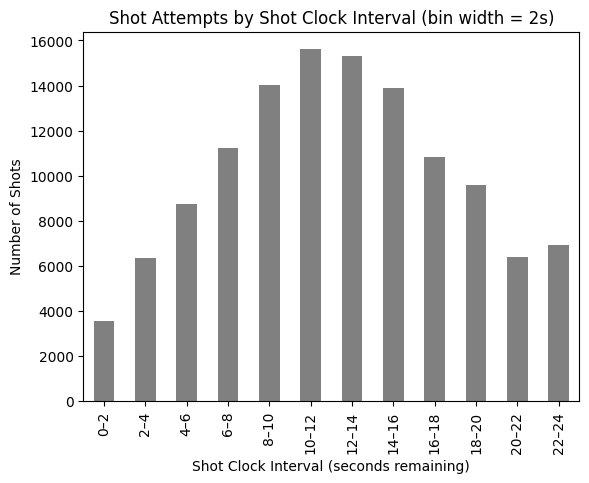

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


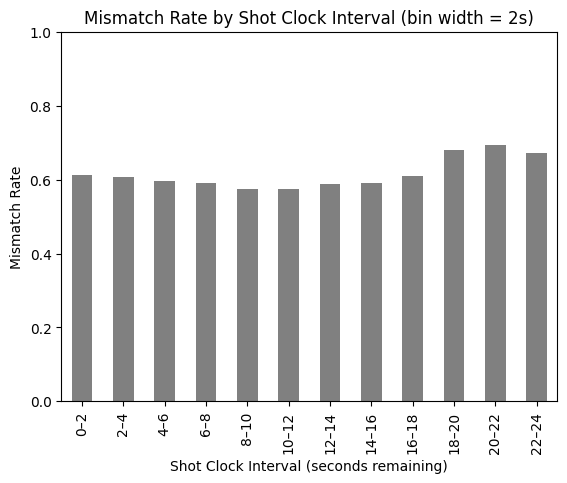

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


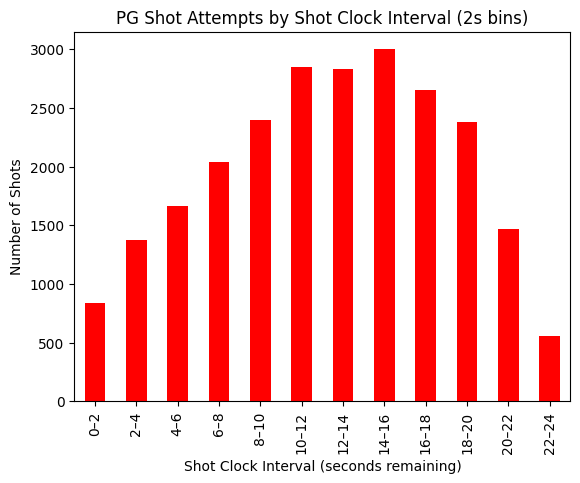

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


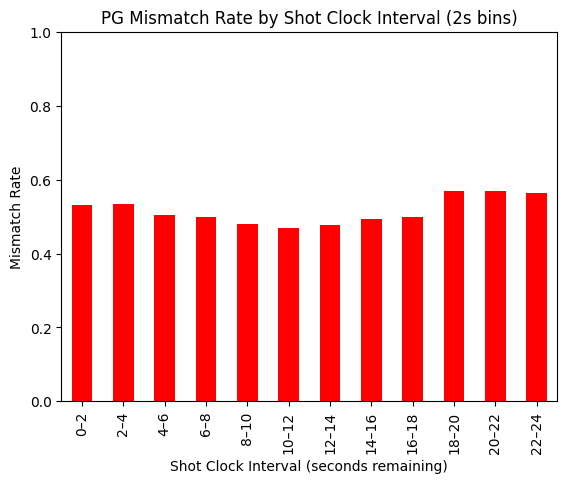

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


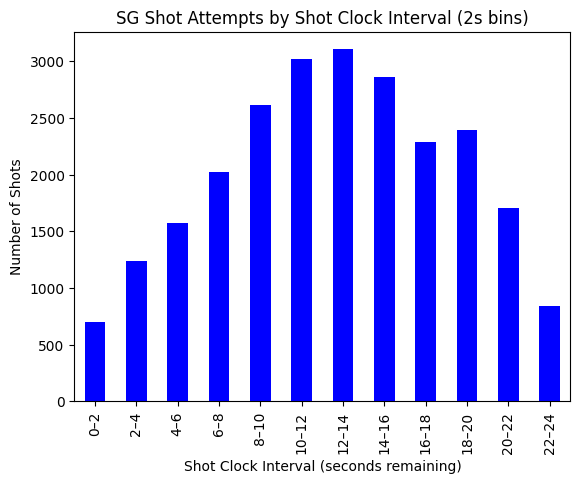

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


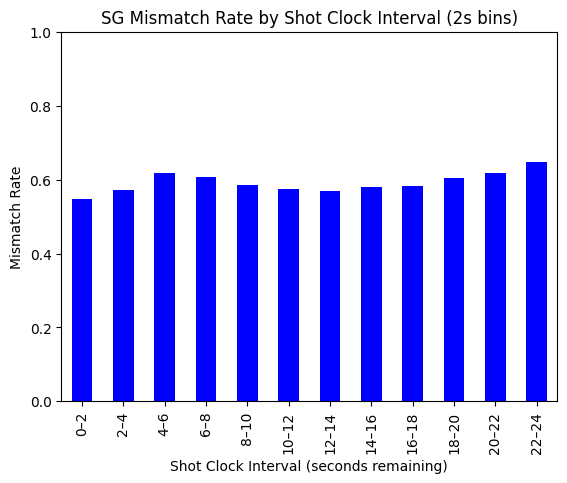

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


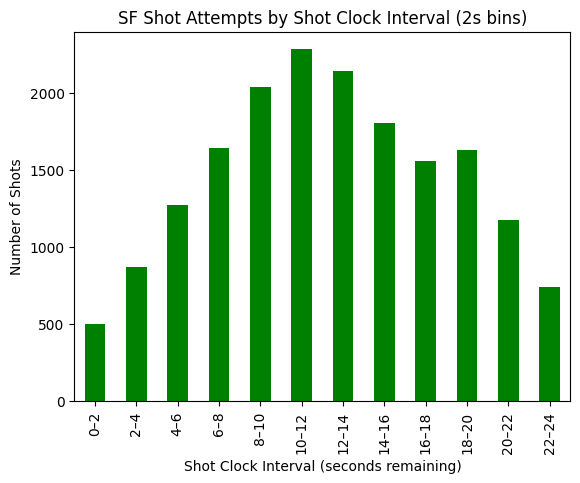

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


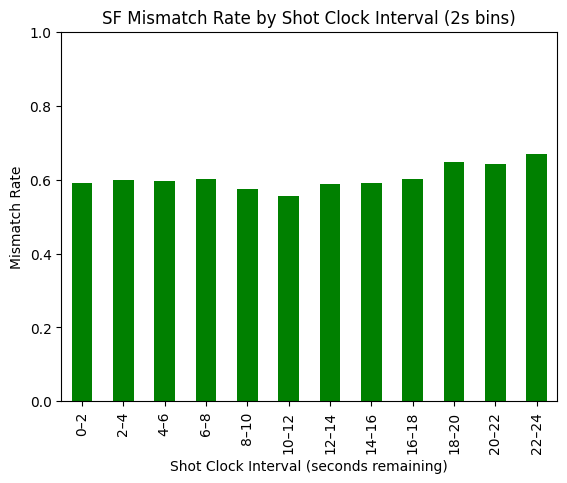

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


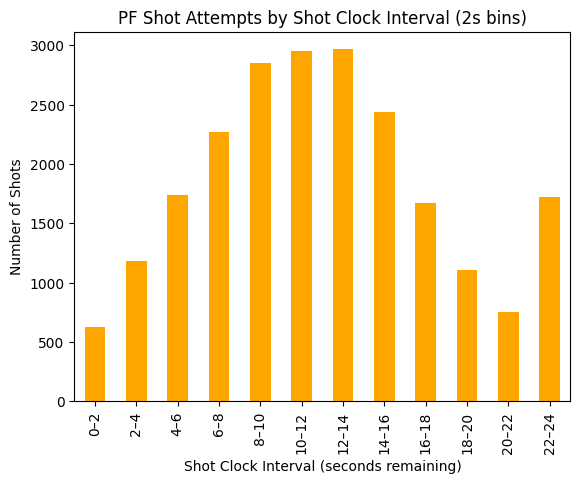

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


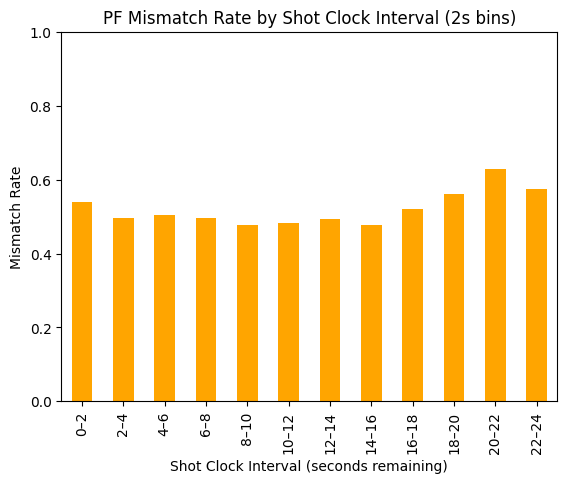

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_pos = subset.groupby('sc_bin').size()


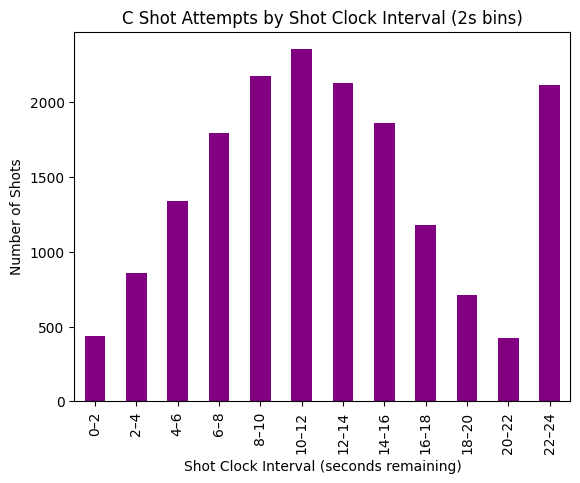

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_72073/661695217.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sc_bin')['mismatch']


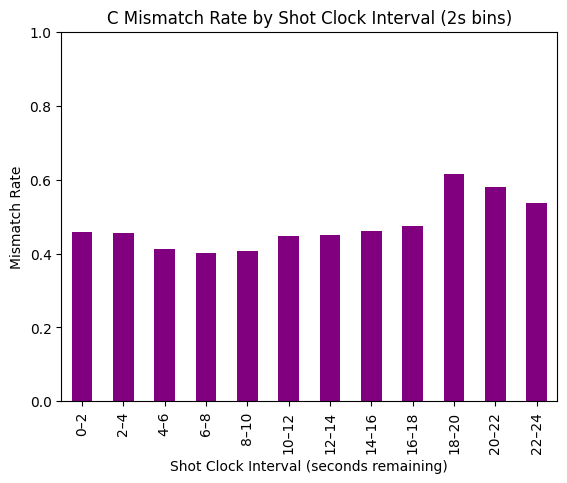

In [ ]:
# ===================== define fixed colors per position =====================
colors = { "PG":"red", "SG":"blue", "SF":"green", "PF":"orange", "C":"purple" }

# ===================== Charts for ALL SHOTS =====================
# Attempts by bin
counts = shotsDF.groupby('sc_bin').size()
ax = counts.plot(kind='bar', color="gray")   # neutral color for all shots
ax.set_title(f"Shot Attempts by Shot Clock Interval (bin width = {bin_width_sec}s)")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Number of Shots")
plt.xticks(rotation=90)
plt.show()

# Mismatch rate by bin (only where positions known)
mismatch_rate = (shotsDF.loc[known]
                 .groupby('sc_bin')['mismatch']
                 .mean())
ax = mismatch_rate.plot(kind='bar', color="gray")
ax.set_title(f"Mismatch Rate by Shot Clock Interval (bin width = {bin_width_sec}s)")
ax.set_xlabel("Shot Clock Interval (seconds remaining)")
ax.set_ylabel("Mismatch Rate")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

# ===================== per-position plots =====================
for pos in ["PG","SG","SF","PF","C"]:
    subset = shotsDF.loc[shotsDF['shooter_pos'] == pos].copy()
    k = subset['mismatch'].notna()

    # Attempts by bin
    counts_pos = subset.groupby('sc_bin').size()
    ax = counts_pos.plot(kind='bar', color=colors.get(pos, "black"))   # <<< NEW
    ax.set_title(f"{pos} Shot Attempts by Shot Clock Interval ({bin_width_sec}s bins)")
    ax.set_xlabel("Shot Clock Interval (seconds remaining)")
    ax.set_ylabel("Number of Shots")
    plt.xticks(rotation=90)
    plt.show()

    # Mismatch rate by bin
    mismatch_rate_pos = (subset.loc[k]
                         .groupby('sc_bin')['mismatch']
                         .mean())
    ax = mismatch_rate_pos.plot(kind='bar', color=colors.get(pos, "black"))  # <<< NEW
    ax.set_title(f"{pos} Mismatch Rate by Shot Clock Interval ({bin_width_sec}s bins)")
    ax.set_xlabel("Shot Clock Interval (seconds remaining)")
    ax.set_ylabel("Mismatch Rate")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata
shotsDF = pd.read_csv('shot_logs.csv')
statsDF = pd.read_csv('players_stats.csv')

# -------------------------------------------------------
# 1) Robust normalizer (fixes 'Last, First', suffixes, case)
#    (REPLACES your old norm_name)
# -------------------------------------------------------
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:                                 # <<< fix: flip "Last, First"
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# -------------------------------------------------------
# 2) Map raw positions to 5 buckets if needed
# -------------------------------------------------------
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

if 'PositionGroups' not in statsDF.columns:
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# -------------------------------------------------------
# 3) BUILD A POSITION LOOKUP (vectorized; REPLACES find_pos)
#    - Normalize statsDF['Name'] once
#    - Create pos_map: normalized name -> PositionGroups
# -------------------------------------------------------
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF
           .drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# OPTIONAL helper if you really want a function:
# def find_pos(name):
#     return pos_map.get(norm_name(name), np.nan)

# -------------------------------------------------------
# 4) Normalize names in shots, map positions, compute mismatch
#    (REPLACES your broken mismatch() + loops)
# -------------------------------------------------------
shotsDF = shotsDF.copy()
shotsDF['_shooter_norm']  = shotsDF['player_name'].map(norm_name)
shotsDF['_defender_norm'] = shotsDF['CLOSEST_DEFENDER'].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))

# -------------------------------------------------------
# 5) Shot clock bins (parameterized)
# -------------------------------------------------------
bin_width_sec = 2
low, high = 0, 24
edges = np.arange(low, high + bin_width_sec, bin_width_sec)
if edges[-1] != high:
    edges = np.append(edges, high)

labels = [f"{int(edges[i])}–{int(edges[i+1])}" for i in range(len(edges)-1)]

s = shotsDF['SHOT_CLOCK'].clip(lower=low, upper=high)
shotsDF['sc_bin'] = pd.cut(s, bins=edges, labels=labels, include_lowest=True, right=True)
shotsDF['sc_bin'] = shotsDF['sc_bin'].cat.as_ordered()

# ======= DROP-IN: Individual player mismatch rates end-to-end =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata

# ------------------ CONFIG ------------------
PLAYER_COL   = 'player_name'       # shotsDF shooter name column
DEFENDER_COL = 'CLOSEST_DEFENDER'  # shotsDF defender name column
POINTS_COL   = 'POINTS'            # optional: points per shot row
MADE_COL     = 'SHOT_MADE_FLAG'    # optional: 1/0 made flag; set to None if not present
SHOTCLOCK_COL= 'SHOT_CLOCK'        # optional: used for per-bin chart
MIN_SHOTS_FOR_TOP = 100            # min known-position shots to include in "top" table
# --------------------------------------------

# 1) Robust normalizer (fixes 'Last, First', accents, suffixes, spaces, case)
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:  # flip "Last, First" -> "First Last"
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# 2) Map raw positions to 5 buckets if needed
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

# ----- Ensure statsDF has PositionGroups -----
if 'PositionGroups' not in statsDF.columns:
    if 'Pos' not in statsDF.columns:
        raise ValueError("statsDF must have 'PositionGroups' or 'Pos' column.")
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# 3) Build name -> position map (normalized)
statsDF = statsDF.copy()
if 'Name' not in statsDF.columns:
    raise ValueError("statsDF must have a 'Name' column for player names.")
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF
           .drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# 4) Normalize shots names, map positions, compute mismatch
shotsDF = shotsDF.copy()
for col in (PLAYER_COL, DEFENDER_COL):
    if col not in shotsDF.columns:
        raise ValueError(f"shotsDF must have '{col}' column.")
shotsDF['_shooter_norm']  = shotsDF[PLAYER_COL].map(norm_name)
shotsDF['_defender_norm'] = shotsDF[DEFENDER_COL].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known shooter/defender pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))
print("Overall mismatch rate (known only):", round(float(shotsDF.loc[known, 'mismatch'].mean()), 4))

# 5) Per-player aggregates (shots, mismatches, rate, optional points/FG%)
grp = shotsDF.loc[known].groupby('_shooter_norm', as_index=True)
player_mm = grp['mismatch'].agg(shots='size', mismatches='sum')
player_mm['mismatch_rate'] = player_mm['mismatches'] / player_mm['shots']

# Optional: points / PPS
if POINTS_COL in shotsDF.columns:
    player_pts_all = shotsDF.loc[known].groupby('_shooter_norm')[POINTS_COL].sum().rename('total_points')
    player_pts_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[POINTS_COL].sum().rename('mismatch_points')
    player_mm = player_mm.join(player_pts_all, how='left').join(player_pts_mm, how='left').fillna({'mismatch_points':0})
    player_mm['pps_overall']  = player_mm['total_points'] / player_mm['shots']
    # For PPS mismatch, need mismatch shots count (already "mismatches")
    player_mm['pps_mismatch']()


Known pairs: 97284
Total mismatches (known only): 59200
Known shooter/defender pairs: 97284
Total mismatches (known only): 59200
Overall mismatch rate (known only): 0.6085


In [ ]:
#ONE TO RUN
# ======= DROP-IN: Individual player mismatch rates end-to-end (X = Points per Shot) =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata

# ------------------ CONFIG ------------------
PLAYER_COL   = 'player_name'       # shotsDF shooter name column
DEFENDER_COL = 'CLOSEST_DEFENDER'  # shotsDF defender name column
POINTS_COL   = 'PTS'            # points on the shot row (required for PPS)
MADE_COL     = 'SHOT_MADE_FLAG'    # optional: 1/0 made flag; set to None if not present
SHOTCLOCK_COL= 'SHOT_CLOCK'        # optional: used for per-bin chart
MIN_SHOTS_FOR_TOP = 100            # min known-position shots to include in "top" table
# --------------------------------------------

# 1) Robust normalizer (fixes 'Last, First', accents, suffixes, spaces, case)
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:  # flip "Last, First" -> "First Last"
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# 2) Map raw positions to 5 buckets if needed
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan


    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# 3) Build name -> position map (normalized)
statsDF = statsDF.copy()
if 'Name' not in statsDF.columns:
    raise ValueError("statsDF must have a 'Name' column for player names.")
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (
    statsDF.drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups']
)

# 4) Normalize shots names, map positions, compute mismatch
shotsDF = shotsDF.copy()
for col in (PLAYER_COL, DEFENDER_COL):
    if col not in shotsDF.columns:
        raise ValueError(f"shotsDF must have '{col}' column.")
if POINTS_COL not in shotsDF.columns:
    raise ValueError(f"shotsDF must have '{POINTS_COL}' column to compute PPS.")

shotsDF['_shooter_norm']  = shotsDF[PLAYER_COL].map(norm_name)
shotsDF['_defender_norm'] = shotsDF[DEFENDER_COL].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known shooter/defender pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))
print("Overall mismatch rate (known only):", round(float(shotsDF.loc[known, 'mismatch'].mean()), 4))

# 5) Per-player aggregates (shots, mismatches, rate, PPS, optional FG%)
grp = shotsDF.loc[known].groupby('_shooter_norm', as_index=True)
player_mm = grp['mismatch'].agg(shots='size', mismatches='sum')
player_mm['mismatch_rate'] = player_mm['mismatches'] / player_mm['shots']

# Points / PPS metrics
player_pts_all = shotsDF.loc[known].groupby('_shooter_norm')[POINTS_COL].sum().rename('total_points')
player_pts_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[POINTS_COL].sum().rename('mismatch_points')
player_mm = player_mm.join(player_pts_all, how='left').join(player_pts_mm, how='left').fillna({'mismatch_points':0})

# Overall PPS = total points / total shots (this is our new X metric)
player_mm['pps_overall']  = player_mm['total_points'] / player_mm['shots']

# PPS on mismatch-only shots (optional; not used for X but useful to inspect)
player_mm['pps_mismatch'] = np.where(
    player_mm['mismatches'] > 0,
    player_mm['mismatch_points'] / player_mm['mismatches'],
    np.nan
)

# Optional: FG%
if MADE_COL and MADE_COL in shotsDF.columns:
    made_all = shotsDF.loc[known].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_all')
    made_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_mm')
    player_mm = player_mm.join(made_all, how='left').join(made_mm, how='left').fillna({'fg_made_mm':0})
    player_mm['fg_pct_overall']  = player_mm['fg_made_all'] / player_mm['shots']
    player_mm['fg_pct_mismatch'] = np.where(
        player_mm['mismatches'] > 0,
        player_mm['fg_made_mm'] / player_mm['mismatches'],
        np.nan
    )

# Attach a display name and (optional) most-common position for reference
name_lookup = (shotsDF.groupby('_shooter_norm')[PLAYER_COL]
               .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
               .rename('display_name'))
pos_lookup = (shotsDF.groupby('_shooter_norm')['shooter_pos']
              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
              .rename('pos'))
player_mm = player_mm.join(name_lookup, how='left').join(pos_lookup, how='left')

# Sort a convenient default view (by PPS then mismatch rate)
player_mm = player_mm.sort_values(['pps_overall','mismatch_rate'], ascending=[False, False])

# Show a quick preview
print("\nPer-player table (preview):")
print(player_mm.head(10))

# 6) Helper: inspect ONE player (name can be in any format; we normalize)
def player_mismatch_summary(player_name):
    pname = norm_name(player_name)
    pshots = shotsDF.loc[known & (shotsDF['_shooter_norm'] == pname)].copy()
    if pshots.empty:
        print(f"No shots with known positions for: {player_name}")
        return
    shots = len(pshots)
    mism  = int(pshots['mismatch'].sum())
    rate  = pshots['mismatch'].mean()
    disp  = player_mm.loc[pname, 'display_name'] if pname in player_mm.index else player_name

    print(f"\nPlayer: {disp}  (normalized: {pname})")
    print(f"Shots (known): {shots}")
    print(f"Mismatches: {mism}")
    print(f"Mismatch rate: {rate:.3f}")

    # By defender position
    if 'defender_pos' in pshots.columns:
        by_def = pshots.groupby('defender_pos')['mismatch'].mean().sort_values(ascending=False)
        print("\nMismatch rate by defender position:")
        print(by_def)

    # By shot clock bin (if available)
    if SHOTCLOCK_COL in shotsDF.columns:
        if 'sc_bin' not in shotsDF.columns:
            bin_width_sec = 2
            edges = np.arange(0, 24 + bin_width_sec, bin_width_sec)
            if edges[-1] != 24: edges = np.append(edges, 24)
            labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(len(edges)-1)]
            shotsDF['sc_bin'] = pd.cut(shotsDF[SHOTCLOCK_COL].clip(0,24), bins=edges,
                                       labels=labels, include_lowest=True, right=True)
        by_bin = pshots.groupby('sc_bin')['mismatch'].mean()
        ax = by_bin.plot(kind='bar')
        ax.set_title(f"Mismatch Rate by Shot Clock Interval — {disp}")
        ax.set_ylabel("Mismatch Rate")
        ax.set_xlabel("Shot Clock Interval")
        plt.ylim(0,1)
        plt.xticks(rotation=90)
        plt.show()

# 7) “Top players by mismatch rate” table (filter by shots for stability)
top_players = player_mm[player_mm['shots'] >= MIN_SHOTS_FOR_TOP] \
                .sort_values('mismatch_rate', ascending=False)
print(f"\nTop players by mismatch rate (min {MIN_SHOTS_FOR_TOP} known shots):")
print(top_players.head(15))

# === Interactive scatter with hover (Plotly): X = PPS (Points Per Shot) ===
import plotly.express as px

MIN_SHOTS = 50
scatter_df = player_mm.loc[player_mm['shots'] >= MIN_SHOTS].copy()

# Ensure position exists; fill unknowns
scatter_df['pos'] = scatter_df['pos'].fillna('UNK')

# Fixed color mapping (optional)
pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

# Pretty fields for hover
scatter_df['mismatch_rate_pct'] = (scatter_df['mismatch_rate'] * 100).round(2)
scatter_df['pps_overall_round'] = scatter_df['pps_overall'].round(3)

fig = px.scatter(
    scatter_df.reset_index(),
    x="pps_overall",                 # <-- X is now Points Per Shot
    y="mismatch_rate",
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="shots",                    # bubble size by shot volume
    size_max=18,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "mismatches": ":,",
        "pps_overall_round": True,
        "mismatch_rate_pct": True
    },
    labels={
        "pps_overall": "Points per Shot (PPS)",
        "mismatch_rate": "Mismatch Rate",
        "pos": "Position"
    },
    title=f"Mismatch Rate vs. Points per Shot (min {MIN_SHOTS} shots) — hover for details",
)

# Format axes
fig.update_yaxes(tickformat=".0%", range=[0, 1])
fig.update_xaxes(title_text="Points per Shot (PPS)", tickformat=".2f")

# Layout polish
fig.update_layout(
    legend_title_text="Position",
    margin=dict(l=60, r=20, t=60, b=60),
)

# Optional: save a shareable HTML file
fig.write_html("player_mismatch_rate_scatter.html", include_plotlyjs="cdn")
print("Saved interactive chart to: player_mismatch_rate_scatter.html")

# Try to render in-notebook; fallback to browser
import plotly.io as pio
try:
    import nbformat
    pio.renderers.default = "notebook_connected"
except Exception:
    pio.renderers.default = "browser"

fig.show()

# -------- Example usage ----------
# player_mismatch_summary("LeBron James")
# player_mismatch_summary("James, LeBron")  # works too
# player_mm.loc[norm_name("LeBron James")]  # row for exact player


Known shooter/defender pairs: 97284
Total mismatches (known only): 59200
Overall mismatch rate (known only): 0.6085

Per-player table (preview):
                shots  mismatches  mismatch_rate  total_points  \
_shooter_norm                                                    
deandre jordan    353         221       0.626062           504   
tyson chandler    294         179       0.608844           404   
kyle korver       435         243       0.558621           579   
james johnson     278         205       0.737410           356   
luke babbitt      135          88       0.651852           168   
rudy gobert       240         143       0.595833           298   
greg smith         39          32       0.820513            48   
alexis ajinca     164          89       0.542683           198   
ed davis          307         206       0.671010           366   
stephen curry     851         466       0.547591          1012   

                mismatch_points  pps_overall  pps_mismatch    

In [ ]:
# ======= DROP-IN: Individual player mismatch rates end-to-end =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata

# ------------------ CONFIG ------------------
PLAYER_COL   = 'player_name'       # shotsDF shooter name column
DEFENDER_COL = 'CLOSEST_DEFENDER'  # shotsDF defender name column
POINTS_COL   = 'POINTS'            # optional: points per shot row
MADE_COL     = 'SHOT_MADE_FLAG'    # optional: 1/0 made flag; set to None if not present
SHOTCLOCK_COL= 'SHOT_CLOCK'        # optional: used for per-bin chart
MIN_SHOTS_FOR_TOP = 100            # min known-position shots to include in "top" table
# --------------------------------------------

# 1) Robust normalizer (fixes 'Last, First', accents, suffixes, spaces, case)
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:  # flip "Last, First" -> "First Last"
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# 2) Map raw positions to 5 buckets if needed
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

# ----- Ensure statsDF has PositionGroups -----
if 'PositionGroups' not in statsDF.columns:
    if 'Pos' not in statsDF.columns:
        raise ValueError("statsDF must have 'PositionGroups' or 'Pos' column.")
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# 3) Build name -> position map (normalized)
statsDF = statsDF.copy()
if 'Name' not in statsDF.columns:
    raise ValueError("statsDF must have a 'Name' column for player names.")
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF
           .drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# 4) Normalize shots names, map positions, compute mismatch
shotsDF = shotsDF.copy()
for col in (PLAYER_COL, DEFENDER_COL):
    if col not in shotsDF.columns:
        raise ValueError(f"shotsDF must have '{col}' column.")
shotsDF['_shooter_norm']  = shotsDF[PLAYER_COL].map(norm_name)
shotsDF['_defender_norm'] = shotsDF[DEFENDER_COL].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known shooter/defender pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))
print("Overall mismatch rate (known only):", round(float(shotsDF.loc[known, 'mismatch'].mean()), 4))

# 5) Per-player aggregates (shots, mismatches, rate, optional points/FG%)
grp = shotsDF.loc[known].groupby('_shooter_norm', as_index=True)
player_mm = grp['mismatch'].agg(shots='size', mismatches='sum')
player_mm['mismatch_rate'] = player_mm['mismatches'] / player_mm['shots']

# Optional: points / PPS
if POINTS_COL in shotsDF.columns:
    player_pts_all = shotsDF.loc[known].groupby('_shooter_norm')[POINTS_COL].sum().rename('total_points')
    player_pts_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[POINTS_COL].sum().rename('mismatch_points')
    player_mm = player_mm.join(player_pts_all, how='left').join(player_pts_mm, how='left').fillna({'mismatch_points':0})
    player_mm['pps_overall']  = player_mm['total_points'] / player_mm['shots']
    # For PPS mismatch, need mismatch shots count (already "mismatches")
    player_mm['pps_mismatch'] = np.where(player_mm['mismatches']>0,
                                         player_mm['mismatch_points']/player_mm['mismatches'],
                                         np.nan)

# Optional: FG%
if MADE_COL and MADE_COL in shotsDF.columns:
    made_all = shotsDF.loc[known].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_all')
    made_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_mm')
    player_mm = player_mm.join(made_all, how='left').join(made_mm, how='left').fillna({'fg_made_mm':0})
    player_mm['fg_pct_overall']  = player_mm['fg_made_all'] / player_mm['shots']
    player_mm['fg_pct_mismatch'] = np.where(player_mm['mismatches']>0,
                                            player_mm['fg_made_mm']/player_mm['mismatches'],
                                            np.nan)

# Attach a display name and (optional) most-common position for reference
name_lookup = (shotsDF.groupby('_shooter_norm')[PLAYER_COL]
               .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
               .rename('display_name'))
pos_lookup = (shotsDF.groupby('_shooter_norm')['shooter_pos']
              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
              .rename('pos'))
player_mm = player_mm.join(name_lookup, how='left').join(pos_lookup, how='left')

# Sort a convenient default view
player_mm = player_mm.sort_values(['shots','mismatch_rate'], ascending=[False, False])

# Show a quick preview
print("\nPer-player mismatch table (preview):")
print(player_mm.head(10))

# 6) Helper: inspect ONE player (name can be in any format; we normalize)
def player_mismatch_summary(player_name):
    pname = norm_name(player_name)
    pshots = shotsDF.loc[known & (shotsDF['_shooter_norm'] == pname)].copy()
    if pshots.empty:
        print(f"No shots with known positions for: {player_name}")
        return
    shots = len(pshots)
    mism  = int(pshots['mismatch'].sum())
    rate  = pshots['mismatch'].mean()
    disp  = player_mm.loc[pname, 'display_name'] if pname in player_mm.index else player_name
    print(f"\nPlayer: {disp}  (normalized: {pname})")
    print(f"Shots (known): {shots}")
    print(f"Mismatches: {mism}")
    print(f"Mismatch rate: {rate:.3f}")

    # By defender position
    if 'defender_pos' in pshots.columns:
        by_def = pshots.groupby('defender_pos')['mismatch'].mean().sort_values(ascending=False)
        print("\nMismatch rate by defender position:")
        print(by_def)

    # By shot clock bin (if available)
    if SHOTCLOCK_COL in shotsDF.columns:
        # Make bins if not present already
        if 'sc_bin' not in shotsDF.columns:
            bin_width_sec = 2
            edges = np.arange(0, 24 + bin_width_sec, bin_width_sec)
            if edges[-1] != 24: edges = np.append(edges, 24)
            labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(len(edges)-1)]
            shotsDF['sc_bin'] = pd.cut(shotsDF[SHOTCLOCK_COL].clip(0,24), bins=edges,
                                       labels=labels, include_lowest=True, right=True)
        by_bin = pshots.groupby('sc_bin')['mismatch'].mean()
        ax = by_bin.plot(kind='bar')
        ax.set_title(f"Mismatch Rate by Shot Clock Interval — {disp}")
        ax.set_ylabel("Mismatch Rate")
        ax.set_xlabel("Shot Clock Interval")
        plt.ylim(0,1)
        plt.xticks(rotation=90)
        plt.show()

# 7) “Top players by mismatch rate” table (filter by shots for stability)
top_players = player_mm[player_mm['shots'] >= MIN_SHOTS_FOR_TOP] \
                .sort_values('mismatch_rate', ascending=False)
print(f"\nTop players by mismatch rate (min {MIN_SHOTS_FOR_TOP} known shots):")
print(top_players.head(15))


# === Interactive scatter with hover (Plotly) ===
# If plotly isn't installed: pip install plotly
import plotly.express as px

# Choose a stable subset (optional): avoid super noisy points
MIN_SHOTS = 50
scatter_df = player_mm.loc[player_mm['shots'] >= MIN_SHOTS].copy()

# Nice percent label for hover (keeps numeric y for plotting)
scatter_df['mismatch_rate_pct'] = (scatter_df['mismatch_rate'] * 100).round(2)

fig = px.scatter(
    scatter_df.reset_index(),
    x="shots",
    y="mismatch_rate",
    color="pos",
    size="shots",
    
    hover_data={
        "_shooter_norm": False,      # hide normalized key
        "display_name": True,        # show readable name
        "pos": True,                 # show position
        "shots": ":,",               # thousands separator
        "mismatches": ":,",
        "mismatch_rate_pct": True    # show as percent in hover
    },
    labels={"shots": "Known-position shots",
            "mismatch_rate": "Mismatch rate"},
    title="Player Mismatch Rate vs. Shots (hover for name & position)",
)

# Optional axis formatting
fig.update_yaxes(tickformat=".0%")     # show y-axis as %
fig.update_layout(legend_title_text="Position")
import plotly.io as pio
pio.renderers.default = "browser"

fig.show()




# -------- Example usage ----------
# player_mismatch_summary("LeBron James")
# player_mismatch_summary("James, LeBron")  # works too
# player_mm.loc[norm_name("LeBron James")]  # row for exact player

Known shooter/defender pairs: 97284
Total mismatches (known only): 59200
Overall mismatch rate (known only): 0.6085

Per-player mismatch table (preview):
                   shots  mismatches  mismatch_rate       display_name pos
_shooter_norm                                                             
lamarcus aldridge    948         509       0.536920  lamarcus aldridge  PF
james harden         909         570       0.627063       james harden  SG
klay thompson        880         578       0.656818      klay thompson  SG
damian lillard       866         519       0.599307     damian lillard  PG
lebron james         857         505       0.589265       lebron james  SF
stephen curry        851         466       0.547591      stephen curry  PG
kyrie irving         846         477       0.563830       kyrie irving  PG
tyreke evans         812         584       0.719212       tyreke evans  SG
rudy gay             797         493       0.618570           rudy gay  SF
gordon hayward       

In [ ]:

# ========= Replace everything from your "per-player totals" section down with this =========

# Use the same POINTS_COL you set at the very top of the file.
# If your column is actually named 'PTS', set POINTS_COL = 'PTS' ONCE at the top and remove any later redefinition.

# --- Per-player totals aligned to player_mm index (_shooter_norm) ---
per_player_norm = (shotsDF.loc[known]
                   .groupby('_shooter_norm', as_index=True)
                   .agg(
                       total_FGA=('mismatch', 'size'),          # known-position FGAs
                       total_pts=('PTS', 'sum')            # points on those FGAs
                   ))

# Compute PTS/FGA (points per shot)
per_player_norm['pts_per_fga'] = np.where(
    per_player_norm['total_FGA'] > 0,
    per_player_norm['total_pts'] / per_player_norm['total_FGA'],
    np.nan
)

# Join onto player_mm (same index: _shooter_norm)
player_mm = player_mm.join(per_player_norm[['total_pts','pts_per_fga']], how='left')

# Quick preview
print(player_mm[['display_name','pos','shots','mismatch_rate','total_pts','pts_per_fga']].head(10))

# ======================= Plotly scatter: X = PTS/FGA, Y = mismatch rate =======================
import plotly.express as px
import plotly.io as pio

MIN_SHOTS = 50  # filter tiny samples
scatter_df = player_mm.loc[player_mm['shots'] >= MIN_SHOTS].copy()

# If some positions are missing, fill for coloring
scatter_df['pos'] = scatter_df['pos'].fillna('UNK')
scatter_df['mismatch_rate_pct'] = (scatter_df['mismatch_rate'] * 100).round(2)

# Optional fixed colors for consistency
pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

fig = px.scatter(
    scatter_df.reset_index(),
    x="pts_per_fga",                 # ← X axis: points per shot
    y="mismatch_rate",               # ← Y axis: mismatch rate
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="shots",                    # bubble size by attempts
    size_max=20,                     # make bubbles bigger
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "mismatches": ":,",
        "total_pts": ":,",
        "pts_per_fga": ':.3f',
        "mismatch_rate_pct": True
    },
    labels={
        "pts_per_fga": "PTS/FGA (points per shot)",
        "mismatch_rate": "Mismatch rate",
        "pos": "Position",
        "shots": "Known-position shots"
    },
    title=f"PTS/FGA vs. Mismatch Rate (min {MIN_SHOTS} shots) — hover for details",
)

# Format axes
fig.update_yaxes(tickformat=".0%", range=[0, 1])
# Typical NBA range for PTS/FGA is ~0.8–1.6; you can uncomment to focus:
# fig.update_xaxes(range=[0.6, 1.8])

# Use browser renderer to avoid nbformat requirement in notebooks
pio.renderers.default = "browser"
fig.show()


                        display_name pos  shots  mismatch_rate  total_pts  \
_shooter_norm                                                               
lamarcus aldridge  lamarcus aldridge  PF    948       0.536920        880   
james harden            james harden  SG    909       0.627063        945   
klay thompson          klay thompson  SG    880       0.656818        982   
damian lillard        damian lillard  PG    866       0.599307        868   
lebron james            lebron james  SF    857       0.589265        910   
stephen curry          stephen curry  PG    851       0.547591       1012   
kyrie irving            kyrie irving  PG    846       0.563830        896   
tyreke evans            tyreke evans  SG    812       0.719212        752   
rudy gay                    rudy gay  SF    797       0.618570        772   
gordon hayward        gordon hayward  SF    795       0.656604        800   

                   pts_per_fga  
_shooter_norm                   
lamarcus 

In [ ]:
# ========= Mismatch-only PTS/FGA (points per shot vs mismatches only) =========
# Uses the same POINTS_COL you set at the very top. Do NOT redefine it here.

# 1) Per-player mismatch-only totals, aligned to player_mm index (_shooter_norm)
per_player_mm_only = (shotsDF.loc[known & (shotsDF['mismatch'] == 1)]
                      .groupby('_shooter_norm', as_index=True)
                      .agg(
                          mm_FGA=('mismatch', 'size'),       # FGAs that were mismatches
                          mm_pts=('PTS', 'sum')         # points on those mismatch FGAs
                      ))

# 2) Compute mismatch-only PTS/FGA
per_player_mm_only['pts_per_fga_mm'] = np.where(
    per_player_mm_only['mm_FGA'] > 0,
    per_player_mm_only['mm_pts'] / per_player_mm_only['mm_FGA'],
    np.nan
)

# 3) Join onto player_mm (same index: _shooter_norm)
player_mm = player_mm.join(per_player_mm_only[['mm_FGA','mm_pts','pts_per_fga_mm']], how='left')

# Preview: name, pos, attempts, mismatch rate, and mismatch-only PTS/FGA
print(player_mm[['display_name','pos','shots','mismatch_rate','mm_FGA','mm_pts','pts_per_fga_mm']]
      .sort_values('mm_FGA', ascending=False)
      .head(10))

# ======================= Plotly scatter: X = mismatch-only PTS/FGA, Y = mismatch rate =======================
import plotly.express as px
import plotly.io as pio

MIN_MM_SHOTS = 25  # filter to players with enough mismatch attempts to be meaningful
scatter_df = player_mm.loc[player_mm['mm_FGA'] >= MIN_MM_SHOTS].copy()

# If some positions are missing, fill for coloring
scatter_df['pos'] = scatter_df['pos'].fillna('UNK')
scatter_df['mismatch_rate_pct'] = (scatter_df['mismatch_rate'] * 100).round(2)

# Optional fixed colors for consistency
pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

fig = px.scatter(
    scatter_df.reset_index(),
    x="pts_per_fga_mm",              # ← X axis: PTS/FGA on mismatch shots only
    y="mismatch_rate",               # ← Y axis: overall mismatch rate
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="mm_FGA",                   # bubble size = mismatch attempts
    size_max=20,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "mismatches": ":,",
        "mm_FGA": ":,",
        "mm_pts": ":,",
        "pts_per_fga_mm": ':.3f',
        "mismatch_rate_pct": True
    },
    labels={
        "pts_per_fga_mm": "PTS/FGA on mismatch shots",
        "mismatch_rate": "Mismatch rate (overall)",
        "mm_FGA": "Mismatch FGAs",
        "pos": "Position",
        "shots": "Known-position shots"
    },
    title=f"Mismatch-only PTS/FGA vs. Mismatch Rate (min {MIN_MM_SHOTS} mismatch shots) — hover for details",
)

# Format axes
fig.update_yaxes(tickformat=".0%", range=[0, 1])
# Typical NBA range for PTS/FGA is ~0.8–1.6; you can focus if you want:
# fig.update_xaxes(range=[0.6, 1.8])

# Use browser renderer to avoid nbformat issues
pio.renderers.default = "browser"
fig.show()


                        display_name pos  shots  mismatch_rate  mm_FGA  \
_shooter_norm                                                            
brandon knight        brandon knight  SG    728       0.820055     597   
tyreke evans            tyreke evans  SG    812       0.719212     584   
klay thompson          klay thompson  SG    880       0.656818     578   
james harden            james harden  SG    909       0.627063     570   
joe johnson              joe johnson  SG    700       0.804286     563   
pau gasol                  pau gasol  PF    681       0.784141     534   
gordon hayward        gordon hayward  SF    795       0.656604     522   
jimmy butler            jimmy butler  SG    698       0.746418     521   
damian lillard        damian lillard  PG    866       0.599307     519   
lamarcus aldridge  lamarcus aldridge  PF    948       0.536920     509   

                   mm_pts  pts_per_fga_mm  
_shooter_norm                              
brandon knight        5

In [ ]:
# ========= Non-mismatch-only PTS/FGA (points per shot vs non-mismatch shots only) =========
# Uses the same POINTS_COL you set at the very top. Do NOT redefine it here.

# 1) Per-player NON-mismatch totals, aligned to player_mm index (_shooter_norm)
per_player_nonmm = (shotsDF.loc[known & (shotsDF['mismatch'] == 0)]
                    .groupby('_shooter_norm', as_index=True)
                    .agg(
                        nonmm_FGA=('mismatch', 'size'),    # FGAs that were NOT mismatches
                        nonmm_pts=('PTS', 'sum')      # points on those FGAs
                    ))

# 2) Compute non-mismatch-only PTS/FGA
per_player_nonmm['pts_per_fga_nonmm'] = np.where(
    per_player_nonmm['nonmm_FGA'] > 0,
    per_player_nonmm['nonmm_pts'] / per_player_nonmm['nonmm_FGA'],
    np.nan
)

# 3) Join onto player_mm (same index: _shooter_norm)
player_mm = player_mm.join(per_player_nonmm[['nonmm_FGA','nonmm_pts','pts_per_fga_nonmm']], how='left')

# Preview: name, pos, attempts, mismatch rate, and non-mismatch-only PTS/FGA
print(player_mm[['display_name','pos','shots','mismatch_rate','nonmm_FGA','nonmm_pts','pts_per_fga_nonmm']]
      .sort_values('nonmm_FGA', ascending=False)
      .head(10))

# ======================= Plotly scatter: X = non-mismatch-only PTS/FGA, Y = mismatch rate =======================
import plotly.express as px
import plotly.io as pio

MIN_NONMM_SHOTS = 25  # filter to players with enough non-mismatch attempts
scatter_df = player_mm.loc[player_mm['nonmm_FGA'] >= MIN_NONMM_SHOTS].copy()

# If some positions are missing, fill for coloring
scatter_df['pos'] = scatter_df['pos'].fillna('UNK')
scatter_df['mismatch_rate_pct'] = (scatter_df['mismatch_rate'] * 100).round(2)

# Optional fixed colors for consistency
pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

fig = px.scatter(
    scatter_df.reset_index(),
    x="pts_per_fga_nonmm",           # ← X axis: PTS/FGA on non-mismatch shots only
    y="mismatch_rate",               # ← Y axis: overall mismatch rate
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="nonmm_FGA",                # bubble size = non-mismatch attempts
    size_max=20,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "mismatches": ":,",
        "nonmm_FGA": ":,",
        "nonmm_pts": ":,",
        "pts_per_fga_nonmm": ':.3f',
        "mismatch_rate_pct": True
    },
    labels={
        "pts_per_fga_nonmm": "PTS/FGA on non-mismatch shots",
        "mismatch_rate": "Mismatch rate (overall)",
        "nonmm_FGA": "Non-mismatch FGAs",
        "pos": "Position",
        "shots": "Known-position shots"
    },
    title=f"Non-mismatch-only PTS/FGA vs. Mismatch Rate (min {MIN_NONMM_SHOTS} non-mismatch shots) — hover for details",
)

# Format axes
fig.update_yaxes(tickformat=".0%", range=[0, 1])

# Typical NBA range for PTS/FGA is ~0.8–1.6; uncomment to focus:
# fig.update_xaxes(range=[0.6, 1.8])

# Use browser renderer to avoid nbformat issues
pio.renderers.default = "browser"
fig.show()


                        display_name pos  shots  mismatch_rate  nonmm_FGA  \
_shooter_norm                                                               
lamarcus aldridge  lamarcus aldridge  PF    948       0.536920        439   
al jefferson            al jefferson   C    699       0.373391        438   
trey burke                trey burke  PG    720       0.429167        411   
demarcus cousins    demarcus cousins   C    694       0.417867        404   
nikola vucevic        nikola vucevic   C    764       0.489529        390   
stephen curry          stephen curry  PG    851       0.547591        385   
kyrie irving            kyrie irving  PG    846       0.563830        369   
marc gasol                marc gasol   C    712       0.487360        365   
lebron james            lebron james  SF    857       0.589265        352   
blake griffin          blake griffin  PF    771       0.548638        348   

                   nonmm_pts  pts_per_fga_nonmm  
_shooter_norm            

In [ ]:
#How different postions and players make mismatches at different times in the shot clock on average and then what is their effective scoring rate.
# ======= DROP-IN: Individual player mismatch rates end-to-end =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, unicodedata

# ------------------ CONFIG ------------------
PLAYER_COL   = 'player_name'       # shotsDF shooter name column
DEFENDER_COL = 'CLOSEST_DEFENDER'  # shotsDF defender name column
POINTS_COL   = 'PTS'            # optional: points per shot row
MADE_COL     = 'SHOT_MADE_FLAG'    # optional: 1/0 made flag; set to None if not present
SHOTCLOCK_COL= 'SHOT_CLOCK'        # optional: used for per-bin chart
MIN_SHOTS_FOR_TOP = 100            # min known-position shots to include in "top" table
# --------------------------------------------

# 1) Robust normalizer (fixes 'Last, First', accents, suffixes, spaces, case)
def norm_name(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
    if ',' in s:  # flip "Last, First" -> "First Last"
        last, first = [p.strip() for p in s.split(',', 1)]
        s = f"{first} {last}"
    s = re.sub(r'\b(JR|JR\.|SR|SR\.|II|III|IV)\b', '', s, flags=re.IGNORECASE)
    s = re.sub(r'[.]', '', s)
    s = re.sub(r'\s+', ' ', s).strip().lower()
    return s

# 2) Map raw positions to 5 buckets if needed
def map_pos5(p):
    if not isinstance(p, str):
        return np.nan
    p = p.upper()
    for k in ("PG","SG","SF","PF","C"):
        if k in p:
            return k
    if "G" in p: return "SG"
    if "F" in p: return "SF"
    return np.nan

# ----- Ensure statsDF has PositionGroups -----
if 'PositionGroups' not in statsDF.columns:
    if 'Pos' not in statsDF.columns:
        raise ValueError("statsDF must have 'PositionGroups' or 'Pos' column.")
    statsDF['PositionGroups'] = statsDF['Pos'].map(map_pos5)

# 3) Build name -> position map (normalized)
statsDF = statsDF.copy()
if 'Name' not in statsDF.columns:
    raise ValueError("statsDF must have a 'Name' column for player names.")
statsDF['_name_norm'] = statsDF['Name'].map(norm_name)
pos_map = (statsDF
           .drop_duplicates('_name_norm')
           .set_index('_name_norm')['PositionGroups'])

# 4) Normalize shots names, map positions, compute mismatch
shotsDF = shotsDF.copy()
for col in (PLAYER_COL, DEFENDER_COL):
    if col not in shotsDF.columns:
        raise ValueError(f"shotsDF must have '{col}' column.")
shotsDF['_shooter_norm']  = shotsDF[PLAYER_COL].map(norm_name)
shotsDF['_defender_norm'] = shotsDF[DEFENDER_COL].map(norm_name)

shotsDF['shooter_pos']  = shotsDF['_shooter_norm'].map(pos_map)
shotsDF['defender_pos'] = shotsDF['_defender_norm'].map(pos_map)

known = shotsDF['shooter_pos'].notna() & shotsDF['defender_pos'].notna()
shotsDF['mismatch'] = np.where(known & (shotsDF['shooter_pos'] != shotsDF['defender_pos']), 1, 0)

print("Known shooter/defender pairs:", int(known.sum()))
print("Total mismatches (known only):", int(shotsDF.loc[known, 'mismatch'].sum()))
print("Overall mismatch rate (known only):", round(float(shotsDF.loc[known, 'mismatch'].mean()), 4))

# 5) Per-player aggregates (shots, mismatches, rate, optional points/FG%)
grp = shotsDF.loc[known].groupby('_shooter_norm', as_index=True)
player_mm = grp['mismatch'].agg(shots='size', mismatches='sum')
player_mm['mismatch_rate'] = player_mm['mismatches'] / player_mm['shots']

# Optional: points / PPS
if POINTS_COL in shotsDF.columns:
    player_pts_all = shotsDF.loc[known].groupby('_shooter_norm')[POINTS_COL].sum().rename('total_points')
    player_pts_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[POINTS_COL].sum().rename('mismatch_points')
    player_mm = player_mm.join(player_pts_all, how='left').join(player_pts_mm, how='left').fillna({'mismatch_points':0})
    player_mm['pps_overall']  = player_mm['total_points'] / player_mm['shots']
    # For PPS mismatch, need mismatch shots count (already "mismatches")
    player_mm['pps_mismatch'] = np.where(player_mm['mismatches']>0,
                                         player_mm['mismatch_points']/player_mm['mismatches'],
                                         np.nan)
# === NEW: per-player average shot clock (overall) ===
if SHOTCLOCK_COL in shotsDF.columns:
    sc_mean = (shotsDF.loc[known, [ '_shooter_norm', SHOTCLOCK_COL ]]
               .assign(**{SHOTCLOCK_COL: lambda d: d[SHOTCLOCK_COL].clip(0, 24)})
               .groupby('_shooter_norm')[SHOTCLOCK_COL].mean()
               .rename('avg_sc_overall'))
    player_mm = player_mm.join(sc_mean, how='left')
else:
    raise ValueError(f"shotsDF must include '{SHOTCLOCK_COL}' for shot clock analysis.")



# Optional: FG%
if MADE_COL and MADE_COL in shotsDF.columns:
    made_all = shotsDF.loc[known].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_all')
    made_mm  = shotsDF.loc[known & (shotsDF['mismatch'] == 1)].groupby('_shooter_norm')[MADE_COL].sum().rename('fg_made_mm')
    player_mm = player_mm.join(made_all, how='left').join(made_mm, how='left').fillna({'fg_made_mm':0})
    player_mm['fg_pct_overall']  = player_mm['fg_made_all'] / player_mm['shots']
    player_mm['fg_pct_mismatch'] = np.where(player_mm['mismatches']>0,
                                            player_mm['fg_made_mm']/player_mm['mismatches'],
                                            np.nan)

# Attach a display name and (optional) most-common position for reference
name_lookup = (shotsDF.groupby('_shooter_norm')[PLAYER_COL]
               .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
               .rename('display_name'))
pos_lookup = (shotsDF.groupby('_shooter_norm')['shooter_pos']
              .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
              .rename('pos'))
player_mm = player_mm.join(name_lookup, how='left').join(pos_lookup, how='left')

# Sort a convenient default view
player_mm = player_mm.sort_values(['shots','mismatch_rate'], ascending=[False, False])

# Show a quick preview
print("\nPer-player mismatch table (preview):")
print(player_mm.head(10))

# 6) Helper: inspect ONE player (name can be in any format; we normalize)
def player_mismatch_summary(player_name):
    pname = norm_name(player_name)
    pshots = shotsDF.loc[known & (shotsDF['_shooter_norm'] == pname)].copy()
    if pshots.empty:
        print(f"No shots with known positions for: {player_name}")
        return
    shots = len(pshots)
    mism  = int(pshots['mismatch'].sum())
    rate  = pshots['mismatch'].mean()
    disp  = player_mm.loc[pname, 'display_name'] if pname in player_mm.index else player_name
    print(f"\nPlayer: {disp}  (normalized: {pname})")
    print(f"Shots (known): {shots}")
    print(f"Mismatches: {mism}")
    print(f"Mismatch rate: {rate:.3f}")

    # By defender position
    if 'defender_pos' in pshots.columns:
        by_def = pshots.groupby('defender_pos')['mismatch'].mean().sort_values(ascending=False)
        print("\nMismatch rate by defender position:")
        print(by_def)

    # By shot clock bin (if available)
    if SHOTCLOCK_COL in shotsDF.columns:
        # Make bins if not present already
        if 'sc_bin' not in shotsDF.columns:
            bin_width_sec = 2
            edges = np.arange(0, 24 + bin_width_sec, bin_width_sec)
            if edges[-1] != 24: edges = np.append(edges, 24)
            labels = [f"{int(edges[i])}-{int(edges[i+1])}" for i in range(len(edges)-1)]
            shotsDF['sc_bin'] = pd.cut(shotsDF[SHOTCLOCK_COL].clip(0,24), bins=edges,
                                       labels=labels, include_lowest=True, right=True)
        by_bin = pshots.groupby('sc_bin')['mismatch'].mean()
        ax = by_bin.plot(kind='bar')
        ax.set_title(f"Mismatch Rate by Shot Clock Interval — {disp}")
        ax.set_ylabel("Mismatch Rate")
        ax.set_xlabel("Shot Clock Interval")
        plt.ylim(0,1)
        plt.xticks(rotation=90)
        plt.show()

# 7) “Top players by mismatch rate” table (filter by shots for stability)
top_players = player_mm[player_mm['shots'] >= MIN_SHOTS_FOR_TOP] \
                .sort_values('mismatch_rate', ascending=False)
print(f"\nTop players by mismatch rate (min {MIN_SHOTS_FOR_TOP} known shots):")
print(top_players.head(15))


import plotly.express as px
import plotly.io as pio

MIN_SHOTS = 50
scatter_df = player_mm.loc[
    (player_mm['shots'] >= MIN_SHOTS) &
    player_mm['pps_overall'].notna() &
    player_mm['avg_sc_overall'].notna()
].copy()

# Nice, readable hover values
scatter_df['pps_overall_round'] = scatter_df['pps_overall'].round(3)
scatter_df['avg_sc_overall_round'] = scatter_df['avg_sc_overall'].round(2)

fig = px.scatter(
    scatter_df.reset_index(),
    x="pps_overall",                 # points per shot
    y="avg_sc_overall",              # average shot-clock time (seconds)
    color="pos",
    size="shots",
    hover_data={
        "_shooter_norm": False,
        "display_name": True,
        "pos": True,
        "shots": ":,",
        "mismatches": ":,",
        "pps_overall_round": True,
        "avg_sc_overall_round": True
    },
    labels={
        "pps_overall": "Points per Shot (PPS)",
        "avg_sc_overall": "Avg Shot Clock at Attempt (s)"
    },
    title="Avg Shot Clock vs. Points per Shot (min {MIN_SHOTS} known-position shots)",
)

# Axes formatting
fig.update_yaxes(range=[0, 24], tickformat=".1f")   # 0–24 seconds
fig.update_xaxes(tickformat=".2f")
fig.update_layout(legend_title_text="Position")

pio.renderers.default = "browser"
fig.show()


Known shooter/defender pairs: 97284
Total mismatches (known only): 59200
Overall mismatch rate (known only): 0.6085

Per-player mismatch table (preview):
                   shots  mismatches  mismatch_rate  total_points  \
_shooter_norm                                                       
lamarcus aldridge    948         509       0.536920           880   
james harden         909         570       0.627063           945   
klay thompson        880         578       0.656818           982   
damian lillard       866         519       0.599307           868   
lebron james         857         505       0.589265           910   
stephen curry        851         466       0.547591          1012   
kyrie irving         846         477       0.563830           896   
tyreke evans         812         584       0.719212           752   
rudy gay             797         493       0.618570           772   
gordon hayward       795         522       0.656604           800   

                 

In [ ]:
# ========= Per-player totals: PTS/FGA and plot (clean version) =========

# 0) Guard: ensure points col exists
if 'PTS' not in shotsDF.columns:
    raise KeyError(f"POINTS_COL='{POINTS_COL}' not found in shotsDF. "
                   f"Available columns: {list(shotsDF.columns)}")

# 1) Per-player totals aligned to _shooter_norm
per_player_norm = (
    shotsDF.loc[known]
           .groupby('_shooter_norm', as_index=True)
           .agg(
               total_FGA=('mismatch', 'size'),     # known-position FGAs == shots
               total_pts=(POINTS_COL, 'sum')       # total points
           )
)

# 2) Compute PTS/FGA (points per shot)
per_player_norm['pts_per_fga'] = np.where(
    per_player_norm['total_FGA'] > 0,
    per_player_norm['total_pts'] / per_player_norm['total_FGA'],
    np.nan
)

# 3) Join onto player_mm safely (drop overlaps if present)
player_mm = player_mm.drop(columns=['total_pts', 'pts_per_fga'], errors='ignore')
player_mm = player_mm.join(per_player_norm[['total_pts', 'pts_per_fga']], how='left')

# Optional quick preview
print(player_mm[['display_name','pos','shots','avg_sc_overall','total_pts','pts_per_fga']].head(10))

# ======================= Plotly scatter: X = PTS/FGA, Y = avg shot clock =======================
import plotly.express as px
import plotly.io as pio

MIN_SHOTS = 50  # filter tiny samples
scatter_df = player_mm.loc[
    (player_mm['shots'] >= MIN_SHOTS) &
    player_mm['pts_per_fga'].notna() &
    player_mm['avg_sc_overall'].notna()
].copy()

# Clean hover fields
scatter_df['pts_per_fga_round']    = scatter_df['pts_per_fga'].round(3)
scatter_df['avg_sc_overall_round'] = scatter_df['avg_sc_overall'].round(2)
scatter_df['pos'] = scatter_df['pos'].fillna('UNK')

# Optional consistent ordering/colors
pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

fig = px.scatter(
    scatter_df.reset_index(),
    x="pts_per_fga",                 # X: points per shot (PTS/FGA)
    y="avg_sc_overall",              # Y: average shot-clock time (seconds)
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="shots",
    size_max=22,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "total_pts": ":,",
        "pts_per_fga_round": True,
        "avg_sc_overall_round": True
    },
    labels={
        "pts_per_fga": "PTS/FGA (points per shot)",
        "avg_sc_overall": "Avg Shot Clock at Attempt (s)",
        "pos": "Position",
        "shots": "Known-position shots"
    },
    title=f"Avg Shot Clock vs. PTS/FGA (min {MIN_SHOTS} shots) — hover for details",
)

# Axes formatting
fig.update_yaxes(range=[0, 24], tickformat=".1f")  # 0–24 seconds
fig.update_xaxes(tickformat=".2f")                 # typical PTS/FGA ~0.8–1.6

pio.renderers.default = "browser"
fig.show()


                        display_name pos  shots  avg_sc_overall  total_pts  \
_shooter_norm                                                                
lamarcus aldridge  lamarcus aldridge  PF    948       11.499890        880   
james harden            james harden  SG    909       12.837442        945   
klay thompson          klay thompson  SG    880       13.748783        982   
damian lillard        damian lillard  PG    866       13.305693        868   
lebron james            lebron james  SF    857       11.905769        910   
stephen curry          stephen curry  PG    851       14.981039       1012   
kyrie irving            kyrie irving  PG    846       13.014286        896   
tyreke evans            tyreke evans  SG    812       12.072129        752   
rudy gay                    rudy gay  SF    797       11.958824        772   
gordon hayward        gordon hayward  SF    795       12.093742        800   

                   pts_per_fga  
_shooter_norm                 

In [ ]:
# ========= Per-player totals: PTS/FGA and plot (clean version) =========

# 0) Guard: ensure points col exists
if 'PTS' not in shotsDF.columns:
    raise KeyError(f"POINTS_COL='{POINTS_COL}' not found in shotsDF. "
                   f"Available columns: {list(shotsDF.columns)}")

# 1) Per-player totals aligned to _shooter_norm
per_player_norm = (
    shotsDF.loc[known]
           .groupby('_shooter_norm', as_index=True)
           .agg(
               total_FGA=('mismatch', 'size'),     # known-position FGAs == shots
               total_pts=(POINTS_COL, 'sum')       # total points
           )
)

# 2) Compute PTS/FGA (points per shot)
per_player_norm['pts_per_fga'] = np.where(
    per_player_norm['total_FGA'] > 0,
    per_player_norm['total_pts'] / per_player_norm['total_FGA'],
    np.nan
)

# 3) Join onto player_mm safely (drop overlaps if present)
player_mm = player_mm.drop(columns=['total_pts', 'pts_per_fga'], errors='ignore')
player_mm = player_mm.join(per_player_norm[['total_pts', 'pts_per_fga']], how='left')

# Optional quick preview
print(player_mm[['display_name','pos','shots','avg_sc_overall','total_pts','pts_per_fga']].head(10))
# ========= Per-player PTS/FGA split by mismatch status =========
# Guard
if POINTS_COL not in shotsDF.columns:
    raise KeyError(f"POINTS_COL='{POINTS_COL}' not found in shotsDF. "
                   f"Available: {list(shotsDF.columns)}")

# --- NON-MISMATCH ONLY ---
per_player_nonmm = (shotsDF.loc[known & (shotsDF['mismatch'] == 0)]
                    .groupby('_shooter_norm', as_index=True)
                    .agg(
                        nonmm_FGA=('mismatch', 'size'),
                        nonmm_pts=(POINTS_COL, 'sum')
                    ))
per_player_nonmm['pts_per_fga_nonmm'] = np.where(
    per_player_nonmm['nonmm_FGA'] > 0,
    per_player_nonmm['nonmm_pts'] / per_player_nonmm['nonmm_FGA'],
    np.nan
)

# --- MISMATCH ONLY ---
per_player_mm_only = (shotsDF.loc[known & (shotsDF['mismatch'] == 1)]
                      .groupby('_shooter_norm', as_index=True)
                      .agg(
                          mm_FGA=('mismatch', 'size'),
                          mm_pts=(POINTS_COL, 'sum')
                      ))
per_player_mm_only['pts_per_fga_mm'] = np.where(
    per_player_mm_only['mm_FGA'] > 0,
    per_player_mm_only['mm_pts'] / per_player_mm_only['mm_FGA'],
    np.nan
)

# Join onto player_mm safely
player_mm = player_mm.drop(columns=[
    'nonmm_FGA','nonmm_pts','pts_per_fga_nonmm',
    'mm_FGA','mm_pts','pts_per_fga_mm'
], errors='ignore')
player_mm = (player_mm
             .join(per_player_nonmm[['nonmm_FGA','nonmm_pts','pts_per_fga_nonmm']], how='left')
             .join(per_player_mm_only[['mm_FGA','mm_pts','pts_per_fga_mm']], how='left'))

# ======================= Plotly scatter: X = PTS/FGA, Y = avg shot clock =======================
import plotly.express as px
import plotly.io as pio

MIN_NONMM_SHOTS = 25
scatter_nonmm = player_mm.loc[
    (player_mm['nonmm_FGA'] >= MIN_NONMM_SHOTS) &
    player_mm['pts_per_fga_nonmm'].notna() &
    player_mm['avg_sc_overall'].notna()
].copy()

scatter_nonmm['pos'] = scatter_nonmm['pos'].fillna('UNK')
scatter_nonmm['pts_per_fga_nonmm_round'] = scatter_nonmm['pts_per_fga_nonmm'].round(3)
scatter_nonmm['avg_sc_overall_round']   = scatter_nonmm['avg_sc_overall'].round(2)

pos_order  = ['PG','SG','SF','PF','C','UNK']
pos_colors = {'PG':'red','SG':'blue','SF':'green','PF':'orange','C':'purple','UNK':'gray'}

fig_nonmm = px.scatter(
    scatter_nonmm.reset_index(),
    x="pts_per_fga_nonmm",
    y="avg_sc_overall",
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="nonmm_FGA",
    size_max=22,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "nonmm_FGA": ":,",
        "nonmm_pts": ":,",
        "pts_per_fga_nonmm_round": True,
        "avg_sc_overall_round": True
    },
    labels={
        "pts_per_fga_nonmm": "PTS/FGA (non-mismatch shots)",
        "avg_sc_overall": "Avg Shot Clock at Attempt (s)",
        "pos": "Position",
        "nonmm_FGA": "Non-mismatch FGAs"
    },
    title=f"Avg Shot Clock vs PTS/FGA — Non-Mismatch Shots (min {MIN_NONMM_SHOTS} non-mismatch FGAs)",
)
fig_nonmm.update_yaxes(range=[0,24], tickformat=".1f")
fig_nonmm.update_xaxes(tickformat=".2f")
pio.renderers.default = "browser"
fig_nonmm.show()



                        display_name pos  shots  avg_sc_overall  total_pts  \
_shooter_norm                                                                
lamarcus aldridge  lamarcus aldridge  PF    948       11.499890        880   
james harden            james harden  SG    909       12.837442        945   
klay thompson          klay thompson  SG    880       13.748783        982   
damian lillard        damian lillard  PG    866       13.305693        868   
lebron james            lebron james  SF    857       11.905769        910   
stephen curry          stephen curry  PG    851       14.981039       1012   
kyrie irving            kyrie irving  PG    846       13.014286        896   
tyreke evans            tyreke evans  SG    812       12.072129        752   
rudy gay                    rudy gay  SF    797       11.958824        772   
gordon hayward        gordon hayward  SF    795       12.093742        800   

                   pts_per_fga  
_shooter_norm                 

In [ ]:
# ========= Per-player totals: PTS/FGA and plot (clean version) =========

# 0) Guard: ensure points col exists
if 'PTS' not in shotsDF.columns:
    raise KeyError(f"POINTS_COL='{POINTS_COL}' not found in shotsDF. "
                   f"Available columns: {list(shotsDF.columns)}")

# 1) Per-player totals aligned to _shooter_norm
per_player_norm = (
    shotsDF.loc[known]
           .groupby('_shooter_norm', as_index=True)
           .agg(
               total_FGA=('mismatch', 'size'),     # known-position FGAs == shots
               total_pts=(POINTS_COL, 'sum')       # total points
           )
)

# 2) Compute PTS/FGA (points per shot)
per_player_norm['pts_per_fga'] = np.where(
    per_player_norm['total_FGA'] > 0,
    per_player_norm['total_pts'] / per_player_norm['total_FGA'],
    np.nan
)

# 3) Join onto player_mm safely (drop overlaps if present)
player_mm = player_mm.drop(columns=['total_pts', 'pts_per_fga'], errors='ignore')
player_mm = player_mm.join(per_player_norm[['total_pts', 'pts_per_fga']], how='left')

# Optional quick preview
print(player_mm[['display_name','pos','shots','avg_sc_overall','total_pts','pts_per_fga']].head(10))
# ========= Per-player PTS/FGA split by mismatch status =========
# Guard
if POINTS_COL not in shotsDF.columns:
    raise KeyError(f"POINTS_COL='{POINTS_COL}' not found in shotsDF. "
                   f"Available: {list(shotsDF.columns)}")

# --- NON-MISMATCH ONLY ---
per_player_nonmm = (shotsDF.loc[known & (shotsDF['mismatch'] == 0)]
                    .groupby('_shooter_norm', as_index=True)
                    .agg(
                        nonmm_FGA=('mismatch', 'size'),
                        nonmm_pts=(POINTS_COL, 'sum')
                    ))
per_player_nonmm['pts_per_fga_nonmm'] = np.where(
    per_player_nonmm['nonmm_FGA'] > 0,
    per_player_nonmm['nonmm_pts'] / per_player_nonmm['nonmm_FGA'],
    np.nan
)

# --- MISMATCH ONLY ---
per_player_mm_only = (shotsDF.loc[known & (shotsDF['mismatch'] == 1)]
                      .groupby('_shooter_norm', as_index=True)
                      .agg(
                          mm_FGA=('mismatch', 'size'),
                          mm_pts=(POINTS_COL, 'sum')
                      ))
per_player_mm_only['pts_per_fga_mm'] = np.where(
    per_player_mm_only['mm_FGA'] > 0,
    per_player_mm_only['mm_pts'] / per_player_mm_only['mm_FGA'],
    np.nan
)

# Join onto player_mm safely
player_mm = player_mm.drop(columns=[
    'nonmm_FGA','nonmm_pts','pts_per_fga_nonmm',
    'mm_FGA','mm_pts','pts_per_fga_mm'
], errors='ignore')
player_mm = (player_mm
             .join(per_player_nonmm[['nonmm_FGA','nonmm_pts','pts_per_fga_nonmm']], how='left')
             .join(per_player_mm_only[['mm_FGA','mm_pts','pts_per_fga_mm']], how='left'))

# ======================= Plotly scatter: X = PTS/FGA, Y = avg shot clock =======================
MIN_MM_SHOTS = 25
scatter_mm = player_mm.loc[
    (player_mm['mm_FGA'] >= MIN_MM_SHOTS) &
    player_mm['pts_per_fga_mm'].notna() &
    player_mm['avg_sc_overall'].notna()
].copy()

scatter_mm['pos'] = scatter_mm['pos'].fillna('UNK')
scatter_mm['pts_per_fga_mm_round'] = scatter_mm['pts_per_fga_mm'].round(3)
scatter_mm['avg_sc_overall_round'] = scatter_mm['avg_sc_overall'].round(2)

fig_mm = px.scatter(
    scatter_mm.reset_index(),
    x="pts_per_fga_mm",
    y="avg_sc_overall",
    color="pos",
    color_discrete_map=pos_colors,
    category_orders={"pos": pos_order},
    size="mm_FGA",
    size_max=22,
    hover_name="display_name",
    hover_data={
        "_shooter_norm": False,
        "pos": True,
        "shots": ":,",
        "mm_FGA": ":,",
        "mm_pts": ":,",
        "pts_per_fga_mm_round": True,
        "avg_sc_overall_round": True
    },
    labels={
        "pts_per_fga_mm": "PTS/FGA (mismatch shots)",
        "avg_sc_overall": "Avg Shot Clock at Attempt (s)",
        "pos": "Position",
        "mm_FGA": "Mismatch FGAs"
    },
    title=f"Avg Shot Clock vs PTS/FGA — Mismatch Shots (min {MIN_MM_SHOTS} mismatch FGAs)",
)
fig_mm.update_yaxes(range=[0,24], tickformat=".1f")
fig_mm.update_xaxes(tickformat=".2f")
fig_mm.show()




                        display_name pos  shots  avg_sc_overall  total_pts  \
_shooter_norm                                                                
lamarcus aldridge  lamarcus aldridge  PF    948       11.499890        880   
james harden            james harden  SG    909       12.837442        945   
klay thompson          klay thompson  SG    880       13.748783        982   
damian lillard        damian lillard  PG    866       13.305693        868   
lebron james            lebron james  SF    857       11.905769        910   
stephen curry          stephen curry  PG    851       14.981039       1012   
kyrie irving            kyrie irving  PG    846       13.014286        896   
tyreke evans            tyreke evans  SG    812       12.072129        752   
rudy gay                    rudy gay  SF    797       11.958824        772   
gordon hayward        gordon hayward  SF    795       12.093742        800   

                   pts_per_fga  
_shooter_norm                 

In [ ]:
#Do players score more per shot on mismatches?
import numpy as np, pandas as pd
from scipy import stats

# Require enough attempts in both contexts to be stable
MIN_EACH = 25
df = player_mm.dropna(subset=['pts_per_fga_mm','pts_per_fga_nonmm']).copy()
df = df[(df['mm_FGA'] >= MIN_EACH) & (df['nonmm_FGA'] >= MIN_EACH)]

delta = df['pts_per_fga_mm'] - df['pts_per_fga_nonmm']

# Paired t-test (mean difference) + nonparametric check
tres = stats.ttest_rel(df['pts_per_fga_mm'], df['pts_per_fga_nonmm'])
wres = stats.wilcoxon(df['pts_per_fga_mm'], df['pts_per_fga_nonmm'])

# Effect size: Cohen's d for paired samples
cohens_d = delta.mean() / delta.std(ddof=1)

# Bootstrap 95% CI for the mean difference
rng = np.random.default_rng(0)
boot_means = [rng.choice(delta, size=len(delta), replace=True).mean() for _ in range(10000)]
ci_lo, ci_hi = np.percentile(boot_means, [2.5, 97.5])

print(f"ΔPTS/FGA (mm - nonmm): {delta.mean():.3f} "
      f"[95% CI {ci_lo:.3f}, {ci_hi:.3f}], "
      f"t={tres.statistic:.2f}, p={tres.pvalue:.4g}, "
      f"Wilcoxon p={wres.pvalue:.4g}, d={cohens_d:.2f}")


ΔPTS/FGA (mm - nonmm): 0.054 [95% CI 0.038, 0.070], t=6.57, p=3.163e-10, Wilcoxon p=2.461e-09, d=0.43


In [ ]:
#Do positions use the shot clock differently?
import numpy as np
from scipy import stats

# Keep only what you need and drop NAs
pos_df = player_mm[['pos','avg_sc_overall']].dropna().copy()

# Optional: require a minimum N per position for stability
MIN_PER_POS = 10
counts = pos_df['pos'].value_counts()
keep_pos = counts[counts >= MIN_PER_POS].index
pos_df = pos_df[pos_df['pos'].isin(keep_pos)]

# ANOVA / Kruskal
groups = [g.values for _, g in pos_df.groupby('pos')['avg_sc_overall']]
f_stat, p_val = stats.f_oneway(*groups)
h_stat, p_kw  = stats.kruskal(*groups)

# Effect sizes (η² and ω²)
grand_mean = pos_df['avg_sc_overall'].mean()
# Between-groups SS using only the numeric series
ssb = sum(g.size * (g.mean() - grand_mean)**2 for _, g in pos_df.groupby('pos')['avg_sc_overall'])
sst = ((pos_df['avg_sc_overall'] - grand_mean)**2).sum()
ssw = sst - ssb

k = pos_df['pos'].nunique()
N = len(pos_df)
msw = ssw / max(N - k, 1)

eta_sq   = ssb / sst if sst > 0 else np.nan
omega_sq = (ssb - (k - 1) * msw) / (sst + msw) if (sst + msw) > 0 else np.nan

print(f"ANOVA: F={f_stat:.2f}, p={p_val:.4g}; Kruskal H={h_stat:.2f}, p={p_kw:.4g}")
print(f"Effect sizes: eta^2={eta_sq:.3f}, omega^2={omega_sq:.3f}")


ANOVA: F=3.75, p=0.005653; Kruskal H=13.27, p=0.01002
Effect sizes: eta^2=0.060, omega^2=0.044


In [ ]:
#Does the mismatch advantage depend on shot-clock time?
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

shots = shotsDF.loc[known, ['_shooter_norm','mismatch', SHOTCLOCK_COL, POINTS_COL, 'shooter_pos']].dropna().copy()
shots[SHOTCLOCK_COL] = shots[SHOTCLOCK_COL].clip(0,24)

# Natural spline for flexibility (5 df)
shots['sc_spline'] = dmatrix("bs(x, df=5, include_intercept=False)",
                             {"x": shots[SHOTCLOCK_COL]}, return_type='dataframe')

# Build design: expand spline columns with mismatch interaction
spline_cols = shots['sc_spline'].columns
for c in spline_cols:
    shots[f"{c}:mismatch"] = shots['sc_spline'][c] * shots['mismatch']

# GLM (Gaussian on PTS per shot; cluster-robust by player)
y = shots[POINTS_COL]
X = pd.concat([shots['mismatch'], shots['sc_spline'], shots[[f"{c}:mismatch" for c in spline_cols]],
               pd.get_dummies(shots['shooter_pos'], prefix='pos', drop_first=True)], axis=1)
X = sm.add_constant(X)

model = sm.GLM(y, X, family=sm.families.Gaussian())
res = model.fit(cov_type='cluster', cov_kwds={'groups': shots['_shooter_norm']})

print(res.summary().tables[1])  # look for the interaction terms {spline}:mismatch


ValueError: Cannot set a DataFrame with multiple columns to the single column sc_spline

In [ ]:
#Which players truly have the biggest “swing” (mm vs non-mm)
from statsmodels.stats.multitest import multipletests

# Per-player paired test (mm vs nonmm) with BH-FDR correction
rows = []
for pid, row in df.iterrows():  # df from Test #1 (players with enough attempts)
    # SE of difference via normal approx over Bernoulli/3pt mixture is messy; use bootstrap p-value:
    rng = np.random.default_rng(0)
    diffs = []
    for _ in range(2000):
        s = rng.choice([1,-1], size=1)  # sign-flip bootstrap for paired diffs
        diffs.append(s[0]*(row['pts_per_fga_mm'] - row['pts_per_fga_nonmm']))
    p_boot = (np.sum(np.array(diffs) >= abs(row['pts_per_fga_mm']-row['pts_per_fga_nonmm']))+1)/ (len(diffs)+1)
    rows.append((row['display_name'], row['pos'], row['mm_FGA'], row['nonmm_FGA'],
                 row['pts_per_fga_mm']-row['pts_per_fga_nonmm'], p_boot))

res_df = pd.DataFrame(rows, columns=['player','pos','mm_FGA','nonmm_FGA','delta_pps','p_raw'])
res_df['p_adj'] = multipletests(res_df['p_raw'], method='fdr_bh')[1]
print(res_df.sort_values('p_adj').head(15))


                player pos  mm_FGA  nonmm_FGA  delta_pps     p_raw     p_adj
0    lamarcus aldridge  PF     509        439   0.023379  0.478761  0.521739
148     darrell arthur  PF     168        131   0.079562  0.478761  0.521739
149        cory joseph  PG     207         91  -0.036577  0.521739  0.521739
150      alan anderson  SG     199         98  -0.178033  0.521739  0.521739
151       donald sloan  PG     180        117  -0.040598  0.521739  0.521739
152    marco belinelli  SG     162        135  -0.150617  0.521739  0.521739
153      jose calderon  PG     154        141  -0.000599  0.521739  0.521739
154     tyson chandler   C     179        115   0.171776  0.478761  0.521739
155      spencer hawes  PF     160        134   0.046828  0.478761  0.521739
156     kevin seraphin   C     158        136   0.069434  0.478761  0.521739
157         mike scott  PF     165        128   0.278267  0.478761  0.521739
158      zaza pachulia   C     143        149   0.118834  0.478761  0.521739

In [ ]:
#Do positions benefit more from mismatches?
from scipy import stats

delta_by_pos = (df.assign(delta_pps=lambda d: d['pts_per_fga_mm'] - d['pts_per_fga_nonmm'])
                  .dropna(subset=['pos']))
groups = [g['delta_pps'].values for _, g in delta_by_pos.groupby('pos')]

f_stat, p_val = stats.f_oneway(*groups)
h_stat, p_kw = stats.kruskal(*groups)
print(f"ANOVA F={f_stat:.2f}, p={p_val:.4g}; Kruskal p={p_kw:.4g}")


ANOVA F=10.23, p=1.226e-07; Kruskal p=6.222e-08


In [ ]:
#Where are “optimal” shot-clock windows by position?
import numpy as np, pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

def peak_sc_by_pos(df_pos, frac=0.2):
    xy = df_pos[[SHOTCLOCK_COL, POINTS_COL]].dropna().copy()
    xy[SHOTCLOCK_COL] = xy[SHOTCLOCK_COL].clip(0,24)
    # Bin to reduce noise; then smooth PPS vs SC
    bins = np.arange(0, 24.1, 1)
    binned = (xy.assign(bin=pd.cut(xy[SHOTCLOCK_COL], bins, include_lowest=True))
                .groupby('bin')[POINTS_COL].mean().reset_index())
    centers = binned['bin'].apply(lambda iv: iv.mid).values
    sm = lowess(binned[POINTS_COL].values, centers, frac=frac, return_sorted=True)
    peak_idx = np.argmax(sm[:,1])
    return sm[peak_idx, 0], sm

for pos, sub in shotsDF.loc[known].groupby('shooter_pos'):
    if len(sub) < 500: 
        continue
    peak_sc, _ = peak_sc_by_pos(sub)
    print(f"{pos}: peak PPS around {peak_sc:.1f}s")


C: peak PPS around 19.5s
PF: peak PPS around 20.5s
PG: peak PPS around 21.5s
SF: peak PPS around 21.5s
SG: peak PPS around 21.5s


/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_3559/246616766.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_3559/246616766.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/2j/xtwf217j69zd4c401c_dmb2c0000gn/T/ipykernel_3559/246616766.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/2j/xtwf217j69zd4c401c_dmb2c000

In [ ]:
#Practical significance: translate to expected points
# Suppose ΔPTS/FGA from Test #1 is delta.mean()
shots_per_game_on_mismatch = 90  # example; compute from your data if you have per-game
expected_pts_gain_per_game = delta.mean() * shots_per_game_on_mismatch
print(f"≈ {expected_pts_gain_per_game:.2f} extra points per game from leveraging mismatches at current volume.")


≈ 4.85 extra points per game from leveraging mismatches at current volume.
